Dask Approach to Non-SQL PTM Queries
--

v01: move away from classes, try to organize the computation 
primarily in dask.
v02: target optimization.

In [1]:
import postproc_dask as post
import six

In [2]:
import matplotlib.pyplot as plt
import conc_figure
import six
import stompy.plot.cmap as scmap
from stompy.spatial import proj_utils
from matplotlib import cm
cmap=cm.CMRmap_r
cmap=scmap.cmap_clip(cmap,0.03,1.0)

%matplotlib notebook

In [3]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import re

from stompy.grid import unstructured_grid
from stompy import utils, memoize
from stompy.model.fish_ptm import ptm_config, ptm_tools
from stompy.model.suntans import sun_driver
from scipy.stats import spearmanr

import stompy.plot.cmap as scmap
from scipy import stats
import seaborn as sns
turbo=scmap.load_gradient('turbo.cpt')

Overall Process
===

1. SUNTANS hydro runs
2. SUNTANS average output
3. ptm-formatted average output
4. PTM runs
5. Load data

The top-level query is something like *generate a map of concentrations for...*

filter on:
 - sources $x$
 - settling classes $y$
 - vertical positions $z$
 - horizontal positions $h$

weighted by

 - loading data 
 - age
 
mapped by one of ...

 - bounding box
 - put on hydro grid
 - put on regular grid

and possibly smoothed.

In [6]:
# Experiment level configuration -- small, all python native data.
import cfg_v01 
cfg=dict(cfg_v01.cfg)

In [8]:
# Load the grid into... grid
hydro_path=cfg['sun_paths'][0]
ptm_ds=xr.open_dataset(os.path.join(hydro_path,"ptm_average.nc_0000.nc"))
grid=unstructured_grid.UnstructuredGrid.read_ugrid(ptm_ds,dialect='fishptm')
ptm_ds.close()   

cfg['grid']=grid 

In [9]:
# So far this is only used locally.  Slow to compute (15s)
Msmooth=grid.smooth_matrix()
Msmooth_K=grid.smooth_matrix(K=100*np.ones(grid.Nedges()))

INFO:utils:56849/99089
INFO:utils:56193/99089


In [11]:
# Or could make this delayed and have it execute on each client?
cfg['load_data']=post.get_load_data()

In [12]:
# Hydro timestamps
cfg['hydro_timestamps']=post.load_hydro_timestamps(cfg['sun_paths'])

In [13]:
cfg['bc_ds_d']=post.bc_ds(cfg=cfg)

In [14]:
areas=grid.cells_area()    

In [20]:
# Set this a bit early, as it controls cache location which 
# is needed for some testing.
cfg['manta_out_dir']="manta_sets_20210726d"

# now the 021b runs.
# c suffix: use tighter -0.095 z filter.
# 20200227: start of v03
# 20200302: start of v04
# 20200305: try larger window -- extra 24 hours in both directions.
# 20200312: new sources in ptm data, with v02 stormwater concs.
# 20200330: more new sources.
# 20210210a: dask code, new hydro, new ptm. new year.
# 20210317a: new ptm runs with no SJ loss...
#            has the w_s bug
# 20210317b: fixed w_s bug
# 20210317c: switch to weathered loads
# 20210708c: including beaching and deposition counts.
# 20210726d: other stuff, and now prep to optimize just 3 parameters
os.makedirs(cfg['manta_out_dir'],exist_ok=True)

Next steps
--


1. Recreate some of the figures from before, including on-grid smoothing.  
  a. Sample plot: from the powerpoint. 2017-08-30 to 2017-09-14. Surface particles
     max age of 10 days.   *This plot is similarish -- not exactly the same but close
     enough to rule out fundamental errors*
2. Pull out manta samples as before. Maybe skip putting it on the grid, just
   query a radius.
  a. Implement in this notebook
  b. Move all of this to a module.

In [21]:
ll2utm=proj_utils.mapper('WGS84','EPSG:26910')
# Load the manta data, clean it up
manta_fn='manta_summary-v03.csv'
manta=pd.read_csv(manta_fn)
# manta.head()

In [22]:
godwin_offset_h=post.godwin_offset_h
godwin=post.godwin

In [23]:
import numexpr as ne

In [ ]:
# Streamlined version that only allows 
# tau, shore_factor and bed_factor to change.
# Msmooth is already set.

# Precalculate:
if 1: 
    manta=manta.sort_values('DATE') # helps with locality during precalculation
    storm_factor=1.0
    step=-10000
    precalc={} # idx => stuff.

    # Force mantas to be sorted, so that data from the same day
    # is grouped together.
    last_DATE=None
    df=None

    for idx,rec in manta.iterrows():
        print(idx)
        # since we're just pulling out whole days, cache by day.
        # and pull through the end of that day
        # 5s, all in read_parquet
        if rec.DATE==last_DATE:
            pass
        else:
            df=post.particles_for_date(rec.DATE,cfg=cfg)
            last_DATE=rec.DATE

        # Trawl-specific processing:
        # Pull subset of cells
        # add a cell weighting, and a time weighting for the tidal filter
        cells,weights=post.rec_to_cell_weights(rec,areas=areas,grid=grid,
                                               Msmooth=Msmooth,smooth=step,thresh=1e-5)
        df_spatial=pd.DataFrame(dict(cell=cells,weight_spatial=weights)).set_index('cell')
        df_spatial_sort=df_spatial.sort_index()
        space_cell=df_spatial_sort.index.values
        space_weight=df_spatial_sort['weight_spatial'].values
        df_cell=df.cell.values
        df_idx=np.searchsorted(space_cell,df_cell).clip(0,len(space_cell)-1)
        sel=space_cell[df_idx]==df_cell
        tdf=df[sel].copy()
        weight_spatial=space_weight[df_idx[sel]]

        t_sample=np.datetime64(rec['DATE'])    
        t_center = t_sample+np.timedelta64(8,'h') + np.timedelta64(12,'h')
        delta_hours=((tdf['time']-t_center)/np.timedelta64(1,'h')).astype(np.int32)
        weight_time=godwin[delta_hours+godwin_offset_h]
        age=tdf['time'].values - tdf['rel_time'].values

        age_s=(age/np.timedelta64(1,'s')).astype(np.float32)
        bed_hits=tdf['bed_hits'].values
        shore_hits=tdf['shore_hits'].values
        mp_per_area = (tdf['mp_per_particle'] / areas[tdf['cell']]).values

        group_weight=post.group_weights(tdf,storm_factor)

        # Omits decay, bed, shore weights
        pre_weighted=weight_spatial*weight_time*group_weight*mp_per_area
        # Final code below then needs age_s, bed_hits, shore_hits
        sel=pre_weighted>0.0
        
        bundle=np.zeros(sel.sum(),[('preweighted',np.float32),
                                   ('age_s',np.float32),
                                   ('bed_hits',np.int16),
                                   ('shore_hits',np.int16)])
        bundle['preweighted']=pre_weighted[sel]
        bundle['age_s']=age_s[sel]
        bundle['bed_hits']=bed_hits[sel]
        bundle['shore_hits']=shore_hits[sel]
        
        print(f"Manta sample {idx}: {bundle.nbytes:.2e} bytes, {len(bundle):.2e} elements")
        
        # Can get maybe a factor of 3 by combining duplicates
        df_bundle=pd.DataFrame.from_records(bundle)
        uniquified=df_bundle.groupby(['age_s','bed_hits','shore_hits'])['preweighted'].sum().reset_index()
        bundle=np.zeros(len(uniquified),dtype=bundle.dtype)
        bundle['preweighted']=uniquified['preweighted']
        bundle['age_s']=uniquified['age_s']
        bundle['bed_hits']=uniquified['bed_hits']
        bundle['shore_hits']=uniquified['shore_hits']
        print(f"    uniquified: {bundle.nbytes:.2e} bytes, {len(bundle):.2e} elements")
        
        precalc[idx]=bundle

#                        weights=ne.evaluate('weight_spatial*weight_time*decay*group_weight*bed_weight*shore_weight')
#                        unweighted=mp_per_area
#                        final_weights=weights
#                        # final_concs=weights*mp_per_area
#                        C=ne.evaluate( 'sum(weights*mp_per_area)')

In [60]:
%load_ext line_profiler

In [65]:
def predict_mantas_fast(tau,shore_factor=1e-2,bed_factor=1e-2):
    # tau: np.timedelta64 giving e-folding time scale
    # of loss.
    # shore_factors: particle weight derated by (1-shore_factor)**hits
    # bed_factors: particle weighte derated by (1-bed_factor)**hits
    preds=[]

    tau_s=tau/np.timedelta64(1,'s')

    # HERE: not correct, but good enough to profile
    log_decay_rate=np.float32(-0.001) # np.float32(np.timedelta64(1,'s')/tau)
    log_bed_rate=np.log(np.float32(1-bed_factor))
    log_shore_rate=np.log(np.float32(1-shore_factor))

    for idx,rec in utils.progress(manta.iterrows()):
        print(idx)
        bundle=precalc[idx]
        age_s=bundle['age_s']
        shore_hits=bundle['shore_hits']
        bed_hits=bundle['bed_hits']
        preweighted=bundle['preweighted']
        
        weight=ne.evaluate('exp( age_s*log_decay_rate + shore_hits*log_shore_rate + bed_hits*log_bed_rate )')
                                
        pred=dict(idx=idx,storm_factor=storm_factor,tau_d=tau_s/86400.,
                  step=step,Msmooth_i=0,
                  shore_factor=shore_factor,bed_factor=bed_factor)
        pred['idx']=idx
                                
        C=ne.evaluate( 'sum(preweighted*weight)')
        pred['C_model']=C
        preds.append(pred)

    df_pred=pd.DataFrame(preds)
    df_pred['C_model']=df_pred['C_model'].astype(np.float64)
    manta_pred=df_pred.join(manta,on='idx')
    return manta_pred

In [67]:
%%time
# 6.7s
# 2.8s after combining all rates.
#%lprun -f predict_mantas_fast 
predict_mantas_fast(tau=np.timedelta64(60,'D'),shore_factor=0.01,bed_factor=0.01)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
52
51
49
50
44
47
45
46
48
55
56
53
54
57
58
59
60
61
62
63
64
CPU times: user 13.7 s, sys: 623 ms, total: 14.3 s
Wall time: 2.88 s


,idx,storm_factor,tau_d,step,Msmooth_i,shore_factor,bed_factor,C_model,SampleID,SAMPLE LOCATION,...,part_per_m3_std,part_per_m2_std,part_per_m3_raw_std,part_per_m2_raw_std,part_per_m3_nofiber,part_per_m2_nofiber,part_per_m3_raw_nofiber,part_per_m2_raw_nofiber,x,y
0,0,1.0,60.0,-10000,0,0.01,0.01,3.138336e-05,CB-4-Manta-21Aug2017,CB4,...,0.224191,0.021298,0.442172,0.042006,0.015526,0.001475,0.024841,0.002360,550040.331073,4.198063e+06
1,1,1.0,60.0,-10000,0,0.01,0.01,3.344462e-05,SPB3-Manta-21Aug2017,SPB3,...,1.817781,0.172689,1.928407,0.183199,0.296678,0.028184,0.301706,0.028662,557329.971756,4.209634e+06
2,2,1.0,60.0,-10000,0,0.01,0.01,1.473072e-05,SUB1-Manta-21Aug2017,SUB1,...,NaN,NaN,0.000000,0.000000,0.032671,0.003104,0.039205,0.003724,582363.556136,4.217527e+06
3,3,1.0,60.0,-10000,0,0.01,0.01,2.596021e-05,SPB2-Manta-21Aug2017,SPB2,...,0.210549,0.020002,0.402882,0.038274,0.021966,0.002087,0.034288,0.003257,550464.046320,4.210092e+06
4,4,1.0,60.0,-10000,0,0.01,0.01,5.675972e-05,CB9-Manta-22Aug2017,CB9,...,0.085947,0.008165,0.174186,0.016548,0.085947,0.008165,0.091677,0.008709,562183.425087,4.171973e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,60,1.0,60.0,-10000,0,0.01,0.01,3.129958e-05,MBNMS29-Manta-30Mar2018,MBNMS29,...,NaN,NaN,0.000000,0.000000,0.135344,0.012858,0.141103,0.013405,544796.227890,4.184093e+06
61,61,1.0,60.0,-10000,0,0.01,0.01,3.224145e-05,MBNMS29-Manta-DUP-30Mar2018,MBNMS29,...,NaN,NaN,0.000000,0.000000,0.186997,0.017765,0.193128,0.018347,544611.920969,4.184191e+06
62,62,1.0,60.0,-10000,0,0.01,0.01,3.122042e-08,MBNMS32-Manta-31Mar2018,MBNMS32,...,NaN,NaN,0.000000,0.000000,0.028543,0.002712,0.035130,0.003337,507482.022295,4.143577e+06
63,63,1.0,60.0,-10000,0,0.01,0.01,5.135139e-08,MBNMS31-Manta-31Mar2018,MBNMS31,...,NaN,NaN,0.000000,0.000000,0.023822,0.002263,0.032538,0.003091,537216.634576,4.151868e+06


In [102]:
def metrics(grp):
    obs=grp['part_per_m2_nofiber'].values
    mod=grp['C_model'].values
    
    skill={}
    skill['rho'],skill['rho_p']=spearmanr(obs, mod)
    skill['norm_std']=mod.std() / obs.std()
    skill['norm_mag']=mod.mean() / obs.mean()
    skill['rel_std_obs']=obs.std() / obs.mean()
    skill['rel_std_mod']=mod.std() / mod.mean()
    
    # log-transformed
    min_nonzero=obs[obs>0].min()
    r_log=np.corrcoef(np.log(obs.clip(min_nonzero)),
                      np.log(mod.clip(min_nonzero)))[0,1]
    skill['r_log']=r_log
    
    # Same but drop top/bottom 2 outliers:
    obs_rank=np.argsort(np.argsort(obs))
    sel=(obs_rank>2)&(obs_rank<len(obs)-2)
    r=np.corrcoef(obs[sel], mod[sel])[0,1]
    skill['r_sub']=r
    
    skill['norm_std_sub']=mod[sel].std() / obs[sel].std()
    skill['norm_mag_sub']=mod[sel].mean() / obs[sel].mean()
    skill['rel_std_obs_sub']=obs[sel].std() / obs[sel].mean()
    skill['rel_std_mod_sub']=mod[sel].std() / mod[sel].mean()

    return pd.Series(skill)
   

In [ ]:
if 0:
    # Evaluate effect of smoothing on correlation metrics
    # This one testing evaluation of multiple smooths, steps,
    # tau, etc. in one call.
    taus=[np.timedelta64(int(25*86400),'s')]
    Msmooths=[Msmooth,Msmooth_K]
    mtypes=['grid','constant']
    steps=[0,-10,-100,-1000,-10000,-100000]

    manta_pred=predict_mantas_multi(manta,taus=taus,
                                    Msmooths=Msmooths,
                                    steps=steps,
                                    storm_factors=[1.0])
    manta_pred['Msmooth_label']=[ mtypes[i] for i in manta_pred['Msmooth_i'].values]

    manta_pred.groupby(['Msmooth_label','step','tau_d','storm_factor','bed_factor','shore_factor']).apply(metrics)

    taus=[np.timedelta64(int(d*86400),'s') for d in [1,2,5,10,20,30,45,60]]
    Msmooths=[Msmooth]
    mtypes=['grid']
    steps=[-10000]

    manta_pred_tau=predict_mantas_multi(manta,taus=taus,
                                        Msmooths=Msmooths,
                                        steps=steps,
                                        storm_factors=[1])
    manta_pred_tau['Msmooth_label']=[ mtypes[i] for i in manta_pred_tau['Msmooth_i'].values]

    manta_pred_tau.groupby(['Msmooth_label','step','tau_d','storm_factor','bed_factor','shore_factor']).apply(metrics)

In [104]:
# Master set of predictions
taus=[np.timedelta64(int(d*86400),'s') for d in [5,10,20,30,60]]
Msmooths=[Msmooth] # ,Msmooth_K]
mtypes=['grid'] # ,'constant']
steps=[-10000]
storm_factors=[1.0]
# First go round suggested that 0.001 was too small an increment.
shore_factors=[0,0.02,0.05,0.1,0.2,0.4]
bed_factors=[0,0.02,0.05,0.1,0.2,0.4]

In [105]:
manta_pred_master=predict_mantas_multi(manta,taus=taus,
                                       Msmooths=Msmooths,
                                       steps=steps,
                                       storm_factors=storm_factors,
                                       bed_factors=bed_factors,
                                       shore_factors=shore_factors)
manta_pred_master['Msmooth_label']=[ mtypes[i] for i in manta_pred_master['Msmooth_i'].values]

#manta_pred_master['C_model']=manta_pred_master['C_model'].astype(np.float32)
manta_pred_master.to_parquet('manta_pred_master_v04.parquet')

0
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.36417004 0.66760826 ... 0.94119203 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.07694493 0.35848582 ... 0.85737497 0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.07976639 0.00515377 0.12157658 ... 0.7289999  0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.7223680e-03 1.4272486e-05 1.1529220e-02 ... 5.1200002e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 8.0828321e-12 3.6561611e-05 ... 2.1600005e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.36417004 0.66760826 ... 0.94119203 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.07694493 0.35848582 ... 0.857374

            shore=0.1
shore_weight: [0.07976639 0.00515377 0.12157658 ... 0.7289999  0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.7223680e-03 1.4272486e-05 1.1529220e-02 ... 5.1200002e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 8.0828321e-12 3.6561611e-05 ... 2.1600005e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.36417004 0.66760826 ... 0.94119203 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.07694493 0.35848582 ... 0.85737497 0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.07976639 0.00515377 0.12157658 ... 0.7289999  0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.7223680e-03 1.4272486e-05 1.1529220e-02 ... 5.1200002e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 8.0828321e-12 3.6561611e-05 ... 2.1600005e-01 3.6000004e-

          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.36417004 0.66760826 ... 0.94119203 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.07694493 0.35848582 ... 0.85737497 0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.07976639 0.00515377 0.12157658 ... 0.7289999  0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.7223680e-03 1.4272486e-05 1.1529220e-02 ... 5.1200002e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 8.0828321e-12 3.6561611e-05 ... 2.1600005e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.36417004 0.66760826 ... 0.94119203 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.07694493 0.35848582 ... 0.85737497 0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.07976639 

INFO:utils:1


shore_weight: [4.7383892e-06 8.0828321e-12 3.6561611e-05 ... 2.1600005e-01 3.6000004e-01
 3.6000004e-01]
1
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7385693  0.19467619 ... 0.94119203 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.46329114 0.01568959 ... 0.85737497 0.9025     0.9025    ]
            shore=0.1
shore_weight: [7.9766385e-02 2.0589103e-01 1.9662651e-04 ... 7.2899991e-01 8.0999994e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [4.7223680e-03 3.5184383e-02 1.4134787e-08 ... 5.1200002e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 4.7018536e-04 1.0721422e-18 ... 2.1600005e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7385693  0.194676

shore_weight: [4.7383892e-06 4.7018536e-04 1.0721422e-18 ... 2.1600005e-01 3.6000004e-01
 3.6000004e-01]
        tau=20.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7385693  0.19467619 ... 0.94119203 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.46329114 0.01568959 ... 0.85737497 0.9025     0.9025    ]
            shore=0.1
shore_weight: [7.9766385e-02 2.0589103e-01 1.9662651e-04 ... 7.2899991e-01 8.0999994e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [4.7223680e-03 3.5184383e-02 1.4134787e-08 ... 5.1200002e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 4.7018536e-04 1.0721422e-18 ... 2.1600005e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7385693  0.19467619 ... 0.94119203 0.96040004 0.96040004]
            sh

            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7385693  0.19467619 ... 0.94119203 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.46329114 0.01568959 ... 0.85737497 0.9025     0.9025    ]
            shore=0.1
shore_weight: [7.9766385e-02 2.0589103e-01 1.9662651e-04 ... 7.2899991e-01 8.0999994e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [4.7223680e-03 3.5184383e-02 1.4134787e-08 ... 5.1200002e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 4.7018536e-04 1.0721422e-18 ... 2.1600005e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7385693  0.19467619 ... 0.94119203 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.46329114 0.01568959 ... 0.85737497 0.9025     0.9025    ]
            shore=0.1
shore_weight: [7.9766385e-

INFO:utils:2


2
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7385693  0.61578065 ... 0.94119203 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.46329114 0.29198897 ... 0.85737497 0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.07976639 0.20589103 0.07976639 ... 0.7289999  0.80999994 0.80999994]
            shore=0.2
shore_weight: [0.00472237 0.03518438 0.00472237 ... 0.512      0.64000005 0.64000005]
            shore=0.4
shore_weight: [4.7383892e-06 4.7018536e-04 4.7383892e-06 ... 2.1600005e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7385693  0.61578065 ... 0.94119203 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.46329114 0.29198897 ... 0.85737497 0.9025     0.902

            shore=0.4
shore_weight: [4.7383892e-06 4.7018536e-04 4.7383892e-06 ... 2.1600005e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7385693  0.61578065 ... 0.94119203 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.46329114 0.29198897 ... 0.85737497 0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.07976639 0.20589103 0.07976639 ... 0.7289999  0.80999994 0.80999994]
            shore=0.2
shore_weight: [0.00472237 0.03518438 0.00472237 ... 0.512      0.64000005 0.64000005]
            shore=0.4
shore_weight: [4.7383892e-06 4.7018536e-04 4.7383892e-06 ... 2.1600005e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7385693  0.61578065 ... 0.94119203 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 

shore_weight: [0.00472237 0.03518438 0.00472237 ... 0.512      0.64000005 0.64000005]
            shore=0.4
shore_weight: [4.7383892e-06 4.7018536e-04 4.7383892e-06 ... 2.1600005e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7385693  0.61578065 ... 0.94119203 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.46329114 0.29198897 ... 0.85737497 0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.07976639 0.20589103 0.07976639 ... 0.7289999  0.80999994 0.80999994]
            shore=0.2
shore_weight: [0.00472237 0.03518438 0.00472237 ... 0.512      0.64000005 0.64000005]
            shore=0.4
shore_weight: [4.7383892e-06 4.7018536e-04 4.7383892e-06 ... 2.1600005e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.1
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7385693  0.61578065 ..

INFO:utils:3


3
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7385693  0.19467619 ... 0.94119203 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.46329114 0.01568959 ... 0.85737497 0.9025     0.9025    ]
            shore=0.1
shore_weight: [7.9766385e-02 2.0589103e-01 1.9662651e-04 ... 7.2899991e-01 8.0999994e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [4.7223680e-03 3.5184383e-02 1.4134787e-08 ... 5.1200002e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 4.7018536e-04 1.0721422e-18 ... 2.1600005e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7385693  0.19467619 ... 0.94119203 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.46329114 0.01

        tau=20.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7385693  0.19467619 ... 0.94119203 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.46329114 0.01568959 ... 0.85737497 0.9025     0.9025    ]
            shore=0.1
shore_weight: [7.9766385e-02 2.0589103e-01 1.9662651e-04 ... 7.2899991e-01 8.0999994e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [4.7223680e-03 3.5184383e-02 1.4134787e-08 ... 5.1200002e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 4.7018536e-04 1.0721422e-18 ... 2.1600005e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7385693  0.19467619 ... 0.94119203 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.46329114 0.01568959 ... 0.85737497 0.9025     0.9025    ]
          

            shore=0.02
shore_weight: [0.61578065 0.7385693  0.19467619 ... 0.94119203 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.46329114 0.01568959 ... 0.85737497 0.9025     0.9025    ]
            shore=0.1
shore_weight: [7.9766385e-02 2.0589103e-01 1.9662651e-04 ... 7.2899991e-01 8.0999994e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [4.7223680e-03 3.5184383e-02 1.4134787e-08 ... 5.1200002e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 4.7018536e-04 1.0721422e-18 ... 2.1600005e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7385693  0.19467619 ... 0.94119203 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.46329114 0.01568959 ... 0.85737497 0.9025     0.9025    ]
            shore=0.1
shore_weight: [7.9766385e-02 2.0589103e-01 1.9662651e-04 ... 7.2899991e-01 8.0999994

INFO:utils:4


shore_weight: [4.7383892e-06 4.7018536e-04 1.0721422e-18 ... 2.1600005e-01 3.6000004e-01
 3.6000004e-01]
4
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.66760826 0.7847169  0.46407825 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.35848582 0.54036003 0.14239568 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.12157658 0.28242943 0.01824798 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [1.1529220e-02 6.8719491e-02 2.0769206e-04 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [3.6561611e-05 2.1767842e-03 3.7132022e-09 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.66760826 0.7847169  0.46407825 ... 0.96040004 0

shore_weight: [0.66760826 0.7847169  0.46407825 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.35848582 0.54036003 0.14239568 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.12157658 0.28242943 0.01824798 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [1.1529220e-02 6.8719491e-02 2.0769206e-04 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [3.6561611e-05 2.1767842e-03 3.7132022e-09 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.66760826 0.7847169  0.46407825 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.35848582 0.54036003 0.14239568 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.12157658 0.28242943 0.01824798 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [1.1

shore_weight: [1.1529220e-02 6.8719491e-02 2.0769206e-04 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [3.6561611e-05 2.1767842e-03 3.7132022e-09 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.66760826 0.7847169  0.46407825 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.35848582 0.54036003 0.14239568 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.12157658 0.28242943 0.01824798 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [1.1529220e-02 6.8719491e-02 2.0769206e-04 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [3.6561611e-05 2.1767842e-03 3.7132022e-09 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weigh

INFO:utils:5


shore_weight: [3.6561611e-05 2.1767842e-03 3.7132022e-09 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
5
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.66760826 0.7847169  0.46407825 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.35848582 0.54036003 0.14239568 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.12157658 0.28242943 0.01824798 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [1.1529220e-02 6.8719491e-02 2.0769206e-04 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [3.6561611e-05 2.1767842e-03 3.7132022e-09 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.66760826 0.7847169  0.46407825 ... 0.96040004 0

shore_weight: [0.66760826 0.7847169  0.46407825 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.35848582 0.54036003 0.14239568 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.12157658 0.28242943 0.01824798 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [1.1529220e-02 6.8719491e-02 2.0769206e-04 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [3.6561611e-05 2.1767842e-03 3.7132022e-09 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.66760826 0.7847169  0.46407825 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.35848582 0.54036003 0.14239568 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.12157658 0.28242943 0.01824798 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [1.1

            shore=0.2
shore_weight: [1.1529220e-02 6.8719491e-02 2.0769206e-04 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [3.6561611e-05 2.1767842e-03 3.7132022e-09 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.66760826 0.7847169  0.46407825 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.35848582 0.54036003 0.14239568 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.12157658 0.28242943 0.01824798 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [1.1529220e-02 6.8719491e-02 2.0769206e-04 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [3.6561611e-05 2.1767842e-03 3.7132022e-09 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            

INFO:utils:6


shore_weight: [3.6561611e-05 2.1767842e-03 3.7132022e-09 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
6
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.66760826 0.7847169  0.46407825 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.35848582 0.54036003 0.14239568 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.12157658 0.28242943 0.01824798 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [1.1529220e-02 6.8719491e-02 2.0769206e-04 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [3.6561611e-05 2.1767842e-03 3.7132022e-09 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.66760826 0.7847169  0.46407825 ... 0.96040004 0

shore_weight: [0.66760826 0.7847169  0.46407825 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.35848582 0.54036003 0.14239568 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.12157658 0.28242943 0.01824798 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [1.1529220e-02 6.8719491e-02 2.0769206e-04 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [3.6561611e-05 2.1767842e-03 3.7132022e-09 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.66760826 0.7847169  0.46407825 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.35848582 0.54036003 0.14239568 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.12157658 0.28242943 0.01824798 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [1.1

            shore=0.2
shore_weight: [1.1529220e-02 6.8719491e-02 2.0769206e-04 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [3.6561611e-05 2.1767842e-03 3.7132022e-09 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.66760826 0.7847169  0.46407825 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.35848582 0.54036003 0.14239568 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.12157658 0.28242943 0.01824798 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [1.1529220e-02 6.8719491e-02 2.0769206e-04 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [3.6561611e-05 2.1767842e-03 3.7132022e-09 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            

INFO:utils:7


7
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.66760826 0.7847169  0.46407825 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.35848582 0.54036003 0.14239568 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.12157658 0.28242943 0.01824798 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [1.1529220e-02 6.8719491e-02 2.0769206e-04 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [3.6561611e-05 2.1767842e-03 3.7132022e-09 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.66760826 0.7847169  0.46407825 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.35848582 0.54036003 0.14239568 ... 0.9025  

            shore=0.1
shore_weight: [0.12157658 0.28242943 0.01824798 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [1.1529220e-02 6.8719491e-02 2.0769206e-04 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [3.6561611e-05 2.1767842e-03 3.7132022e-09 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.66760826 0.7847169  0.46407825 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.35848582 0.54036003 0.14239568 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.12157658 0.28242943 0.01824798 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [1.1529220e-02 6.8719491e-02 2.0769206e-04 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [3.6561611e-05 2.1767842e-03 3.7132022e-09 ... 3.6000004e-01 3.6000004e-

          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.66760826 0.7847169  0.46407825 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.35848582 0.54036003 0.14239568 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.12157658 0.28242943 0.01824798 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [1.1529220e-02 6.8719491e-02 2.0769206e-04 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [3.6561611e-05 2.1767842e-03 3.7132022e-09 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.66760826 0.7847169  0.46407825 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.35848582 0.54036003 0.14239568 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.12157658 

INFO:utils:8


shore_weight: [3.6561611e-05 2.1767842e-03 3.7132022e-09 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
11
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7690226  0.85076314 ... 0.96040004 0.8858425  0.9223682 ]
            shore=0.05
shore_weight: [0.29198897 0.513342   0.6634204  ... 0.9025     0.73509187 0.81450623]
            shore=0.1
shore_weight: [0.07976639 0.25418648 0.4304671  ... 0.80999994 0.5314409  0.6560999 ]
            shore=0.2
shore_weight: [0.00472237 0.05497559 0.16777219 ... 0.64000005 0.26214403 0.40960002]
            shore=0.4
shore_weight: [4.7383892e-06 1.3060705e-03 1.6796166e-02 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7690226  0.85076314 ... 0.96040004 0.8858425  0.922368

shore_weight: [0.00472237 0.05497559 0.16777219 ... 0.64000005 0.26214403 0.40960002]
            shore=0.4
shore_weight: [4.7383892e-06 1.3060705e-03 1.6796166e-02 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7690226  0.85076314 ... 0.96040004 0.8858425  0.9223682 ]
            shore=0.05
shore_weight: [0.29198897 0.513342   0.6634204  ... 0.9025     0.73509187 0.81450623]
            shore=0.1
shore_weight: [0.07976639 0.25418648 0.4304671  ... 0.80999994 0.5314409  0.6560999 ]
            shore=0.2
shore_weight: [0.00472237 0.05497559 0.16777219 ... 0.64000005 0.26214403 0.40960002]
            shore=0.4
shore_weight: [4.7383892e-06 1.3060705e-03 1.6796166e-02 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7690226  0.85076314 .

            shore=0.1
shore_weight: [0.07976639 0.25418648 0.4304671  ... 0.80999994 0.5314409  0.6560999 ]
            shore=0.2
shore_weight: [0.00472237 0.05497559 0.16777219 ... 0.64000005 0.26214403 0.40960002]
            shore=0.4
shore_weight: [4.7383892e-06 1.3060705e-03 1.6796166e-02 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7690226  0.85076314 ... 0.96040004 0.8858425  0.9223682 ]
            shore=0.05
shore_weight: [0.29198897 0.513342   0.6634204  ... 0.9025     0.73509187 0.81450623]
            shore=0.1
shore_weight: [0.07976639 0.25418648 0.4304671  ... 0.80999994 0.5314409  0.6560999 ]
            shore=0.2
shore_weight: [0.00472237 0.05497559 0.16777219 ... 0.64000005 0.26214403 0.40960002]
            shore=0.4
shore_weight: [4.7383892e-06 1.3060705e-03 1.6796166e-02 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
          bed=0.1
 

INFO:utils:9


shore_weight: [4.7383892e-06 1.3060705e-03 1.6796166e-02 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
10
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7690226  0.85076314 ... 0.96040004 0.8858425  0.9223682 ]
            shore=0.05
shore_weight: [0.29198897 0.513342   0.6634204  ... 0.9025     0.73509187 0.81450623]
            shore=0.1
shore_weight: [0.07976639 0.25418648 0.4304671  ... 0.80999994 0.5314409  0.6560999 ]
            shore=0.2
shore_weight: [0.00472237 0.05497559 0.16777219 ... 0.64000005 0.26214403 0.40960002]
            shore=0.4
shore_weight: [4.7383892e-06 1.3060705e-03 1.6796166e-02 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7690226  0.85076314 ... 0.96040004 0.8858425  0.922368

shore_weight: [0.00472237 0.05497559 0.16777219 ... 0.64000005 0.26214403 0.40960002]
            shore=0.4
shore_weight: [4.7383892e-06 1.3060705e-03 1.6796166e-02 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7690226  0.85076314 ... 0.96040004 0.8858425  0.9223682 ]
            shore=0.05
shore_weight: [0.29198897 0.513342   0.6634204  ... 0.9025     0.73509187 0.81450623]
            shore=0.1
shore_weight: [0.07976639 0.25418648 0.4304671  ... 0.80999994 0.5314409  0.6560999 ]
            shore=0.2
shore_weight: [0.00472237 0.05497559 0.16777219 ... 0.64000005 0.26214403 0.40960002]
            shore=0.4
shore_weight: [4.7383892e-06 1.3060705e-03 1.6796166e-02 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7690226  0.85076314 .

            shore=0.1
shore_weight: [0.07976639 0.25418648 0.4304671  ... 0.80999994 0.5314409  0.6560999 ]
            shore=0.2
shore_weight: [0.00472237 0.05497559 0.16777219 ... 0.64000005 0.26214403 0.40960002]
            shore=0.4
shore_weight: [4.7383892e-06 1.3060705e-03 1.6796166e-02 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.7690226  0.85076314 ... 0.96040004 0.8858425  0.9223682 ]
            shore=0.05
shore_weight: [0.29198897 0.513342   0.6634204  ... 0.9025     0.73509187 0.81450623]
            shore=0.1
shore_weight: [0.07976639 0.25418648 0.4304671  ... 0.80999994 0.5314409  0.6560999 ]
            shore=0.2
shore_weight: [0.00472237 0.05497559 0.16777219 ... 0.64000005 0.26214403 0.40960002]
            shore=0.4
shore_weight: [4.7383892e-06 1.3060705e-03 1.6796166e-02 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
          bed=0.1
 

INFO:utils:10


shore_weight: [4.7383892e-06 1.3060705e-03 1.6796166e-02 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
8
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.05792658 0.61578065 0.7690226  ... 0.96040004 0.8858425  0.9223682 ]
            shore=0.05
shore_weight: [7.2281586e-04 2.9198897e-01 5.1334202e-01 ... 9.0249997e-01 7.3509187e-01
 8.1450623e-01]
            shore=0.1
shore_weight: [3.5333937e-07 7.9766385e-02 2.5418648e-01 ... 8.0999994e-01 5.3144091e-01
 6.5609992e-01]
            shore=0.2
shore_weight: [2.1661546e-14 4.7223680e-03 5.4975588e-02 ... 6.4000005e-01 2.6214403e-01
 4.0960002e-01]
            shore=0.4
shore_weight: [5.2399800e-32 4.7383892e-06 1.3060705e-03 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.05792658 

shore_weight: [2.1661546e-14 4.7223680e-03 5.4975588e-02 ... 6.4000005e-01 2.6214403e-01
 4.0960002e-01]
            shore=0.4
shore_weight: [5.2399800e-32 4.7383892e-06 1.3060705e-03 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
        tau=20.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.05792658 0.61578065 0.7690226  ... 0.96040004 0.8858425  0.9223682 ]
            shore=0.05
shore_weight: [7.2281586e-04 2.9198897e-01 5.1334202e-01 ... 9.0249997e-01 7.3509187e-01
 8.1450623e-01]
            shore=0.1
shore_weight: [3.5333937e-07 7.9766385e-02 2.5418648e-01 ... 8.0999994e-01 5.3144091e-01
 6.5609992e-01]
            shore=0.2
shore_weight: [2.1661546e-14 4.7223680e-03 5.4975588e-02 ... 6.4000005e-01 2.6214403e-01
 4.0960002e-01]
            shore=0.4
shore_weight: [5.2399800e-32 4.7383892e-06 1.3060705e-03 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
          bed=0.02
            shore=0
shore_weight: [

            shore=0.1
shore_weight: [3.5333937e-07 7.9766385e-02 2.5418648e-01 ... 8.0999994e-01 5.3144091e-01
 6.5609992e-01]
            shore=0.2
shore_weight: [2.1661546e-14 4.7223680e-03 5.4975588e-02 ... 6.4000005e-01 2.6214403e-01
 4.0960002e-01]
            shore=0.4
shore_weight: [5.2399800e-32 4.7383892e-06 1.3060705e-03 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
        tau=60.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.05792658 0.61578065 0.7690226  ... 0.96040004 0.8858425  0.9223682 ]
            shore=0.05
shore_weight: [7.2281586e-04 2.9198897e-01 5.1334202e-01 ... 9.0249997e-01 7.3509187e-01
 8.1450623e-01]
            shore=0.1
shore_weight: [3.5333937e-07 7.9766385e-02 2.5418648e-01 ... 8.0999994e-01 5.3144091e-01
 6.5609992e-01]
            shore=0.2
shore_weight: [2.1661546e-14 4.7223680e-03 5.4975588e-02 ... 6.4000005e-01 2.6214403e-01
 4.0960002e-01]
            shore=0.4
shore_weig

INFO:utils:11


shore_weight: [5.2399800e-32 4.7383892e-06 1.3060705e-03 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
9
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.05792658 0.61578065 0.7690226  ... 0.96040004 0.8858425  0.9223682 ]
            shore=0.05
shore_weight: [7.2281586e-04 2.9198897e-01 5.1334202e-01 ... 9.0249997e-01 7.3509187e-01
 8.1450623e-01]
            shore=0.1
shore_weight: [3.5333937e-07 7.9766385e-02 2.5418648e-01 ... 8.0999994e-01 5.3144091e-01
 6.5609992e-01]
            shore=0.2
shore_weight: [2.1661546e-14 4.7223680e-03 5.4975588e-02 ... 6.4000005e-01 2.6214403e-01
 4.0960002e-01]
            shore=0.4
shore_weight: [5.2399800e-32 4.7383892e-06 1.3060705e-03 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.05792658 

shore_weight: [2.1661546e-14 4.7223680e-03 5.4975588e-02 ... 6.4000005e-01 2.6214403e-01
 4.0960002e-01]
            shore=0.4
shore_weight: [5.2399800e-32 4.7383892e-06 1.3060705e-03 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
        tau=20.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.05792658 0.61578065 0.7690226  ... 0.96040004 0.8858425  0.9223682 ]
            shore=0.05
shore_weight: [7.2281586e-04 2.9198897e-01 5.1334202e-01 ... 9.0249997e-01 7.3509187e-01
 8.1450623e-01]
            shore=0.1
shore_weight: [3.5333937e-07 7.9766385e-02 2.5418648e-01 ... 8.0999994e-01 5.3144091e-01
 6.5609992e-01]
            shore=0.2
shore_weight: [2.1661546e-14 4.7223680e-03 5.4975588e-02 ... 6.4000005e-01 2.6214403e-01
 4.0960002e-01]
            shore=0.4
shore_weight: [5.2399800e-32 4.7383892e-06 1.3060705e-03 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
          bed=0.02
            shore=0
shore_weight: [

            shore=0.1
shore_weight: [3.5333937e-07 7.9766385e-02 2.5418648e-01 ... 8.0999994e-01 5.3144091e-01
 6.5609992e-01]
            shore=0.2
shore_weight: [2.1661546e-14 4.7223680e-03 5.4975588e-02 ... 6.4000005e-01 2.6214403e-01
 4.0960002e-01]
            shore=0.4
shore_weight: [5.2399800e-32 4.7383892e-06 1.3060705e-03 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
        tau=60.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.05792658 0.61578065 0.7690226  ... 0.96040004 0.8858425  0.9223682 ]
            shore=0.05
shore_weight: [7.2281586e-04 2.9198897e-01 5.1334202e-01 ... 9.0249997e-01 7.3509187e-01
 8.1450623e-01]
            shore=0.1
shore_weight: [3.5333937e-07 7.9766385e-02 2.5418648e-01 ... 8.0999994e-01 5.3144091e-01
 6.5609992e-01]
            shore=0.2
shore_weight: [2.1661546e-14 4.7223680e-03 5.4975588e-02 ... 6.4000005e-01 2.6214403e-01
 4.0960002e-01]
            shore=0.4
shore_weig

INFO:utils:12


shore_weight: [5.2399800e-32 4.7383892e-06 1.3060705e-03 ... 3.6000004e-01 4.6656020e-02
 1.2960002e-01]
12
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [7.3703100e-05 9.5839991e-05 1.1711341e-07 ... 9.6040004e-01 8.8584250e-01
 9.0392089e-01]
            shore=0.05
shore_weight: [3.2197019e-11 6.2720398e-11 2.5214103e-18 ... 9.0249997e-01 7.3509187e-01
 7.7378088e-01]
            shore=0.1
shore_weight: [2.8068284e-22 1.1042388e-21 7.1051200e-37 ... 8.0999994e-01 5.3144091e-01
 5.9048992e-01]
            shore=0.2
shore_weight: [0.0000000e+00 4.2038954e-45 0.0000000e+00 ... 6.4000005e-01 2.6214403e-01
 3.2768002e-01]
            shore=0.4
shore_weight: [0.         0.         0.         ... 0.36000004 0.04665602 0.07776001]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [7.3703100e

            shore=0.2
shore_weight: [0.0000000e+00 4.2038954e-45 0.0000000e+00 ... 6.4000005e-01 2.6214403e-01
 3.2768002e-01]
            shore=0.4
shore_weight: [0.         0.         0.         ... 0.36000004 0.04665602 0.07776001]
        tau=20.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [7.3703100e-05 9.5839991e-05 1.1711341e-07 ... 9.6040004e-01 8.8584250e-01
 9.0392089e-01]
            shore=0.05
shore_weight: [3.2197019e-11 6.2720398e-11 2.5214103e-18 ... 9.0249997e-01 7.3509187e-01
 7.7378088e-01]
            shore=0.1
shore_weight: [2.8068284e-22 1.1042388e-21 7.1051200e-37 ... 8.0999994e-01 5.3144091e-01
 5.9048992e-01]
            shore=0.2
shore_weight: [0.0000000e+00 4.2038954e-45 0.0000000e+00 ... 6.4000005e-01 2.6214403e-01
 3.2768002e-01]
            shore=0.4
shore_weight: [0.         0.         0.         ... 0.36000004 0.04665602 0.07776001]
          bed=0.02
            shore=0
shore_weight

            shore=0.1
shore_weight: [2.8068284e-22 1.1042388e-21 7.1051200e-37 ... 8.0999994e-01 5.3144091e-01
 5.9048992e-01]
            shore=0.2
shore_weight: [0.0000000e+00 4.2038954e-45 0.0000000e+00 ... 6.4000005e-01 2.6214403e-01
 3.2768002e-01]
            shore=0.4
shore_weight: [0.         0.         0.         ... 0.36000004 0.04665602 0.07776001]
        tau=60.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [7.3703100e-05 9.5839991e-05 1.1711341e-07 ... 9.6040004e-01 8.8584250e-01
 9.0392089e-01]
            shore=0.05
shore_weight: [3.2197019e-11 6.2720398e-11 2.5214103e-18 ... 9.0249997e-01 7.3509187e-01
 7.7378088e-01]
            shore=0.1
shore_weight: [2.8068284e-22 1.1042388e-21 7.1051200e-37 ... 8.0999994e-01 5.3144091e-01
 5.9048992e-01]
            shore=0.2
shore_weight: [0.0000000e+00 4.2038954e-45 0.0000000e+00 ... 6.4000005e-01 2.6214403e-01
 3.2768002e-01]
            shore=0.4
shore_weig

INFO:utils:13


13
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [7.3703100e-05 9.5839991e-05 1.1711341e-07 ... 9.6040004e-01 8.8584250e-01
 9.0392089e-01]
            shore=0.05
shore_weight: [3.2197019e-11 6.2720398e-11 2.5214103e-18 ... 9.0249997e-01 7.3509187e-01
 7.7378088e-01]
            shore=0.1
shore_weight: [2.8068284e-22 1.1042388e-21 7.1051200e-37 ... 8.0999994e-01 5.3144091e-01
 5.9048992e-01]
            shore=0.2
shore_weight: [0.0000000e+00 4.2038954e-45 0.0000000e+00 ... 6.4000005e-01 2.6214403e-01
 3.2768002e-01]
            shore=0.4
shore_weight: [0.         0.         0.         ... 0.36000004 0.04665602 0.07776001]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [7.3703100e-05 9.5839991e-05 1.1711341e-07 ... 9.6040004e-01 8.8584250e-01
 9.0392089e-01]
            shore=0.05
sh

shore_weight: [0.0000000e+00 4.2038954e-45 0.0000000e+00 ... 6.4000005e-01 2.6214403e-01
 3.2768002e-01]
            shore=0.4
shore_weight: [0.         0.         0.         ... 0.36000004 0.04665602 0.07776001]
        tau=20.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [7.3703100e-05 9.5839991e-05 1.1711341e-07 ... 9.6040004e-01 8.8584250e-01
 9.0392089e-01]
            shore=0.05
shore_weight: [3.2197019e-11 6.2720398e-11 2.5214103e-18 ... 9.0249997e-01 7.3509187e-01
 7.7378088e-01]
            shore=0.1
shore_weight: [2.8068284e-22 1.1042388e-21 7.1051200e-37 ... 8.0999994e-01 5.3144091e-01
 5.9048992e-01]
            shore=0.2
shore_weight: [0.0000000e+00 4.2038954e-45 0.0000000e+00 ... 6.4000005e-01 2.6214403e-01
 3.2768002e-01]
            shore=0.4
shore_weight: [0.         0.         0.         ... 0.36000004 0.04665602 0.07776001]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 

shore_weight: [2.8068284e-22 1.1042388e-21 7.1051200e-37 ... 8.0999994e-01 5.3144091e-01
 5.9048992e-01]
            shore=0.2
shore_weight: [0.0000000e+00 4.2038954e-45 0.0000000e+00 ... 6.4000005e-01 2.6214403e-01
 3.2768002e-01]
            shore=0.4
shore_weight: [0.         0.         0.         ... 0.36000004 0.04665602 0.07776001]
        tau=60.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [7.3703100e-05 9.5839991e-05 1.1711341e-07 ... 9.6040004e-01 8.8584250e-01
 9.0392089e-01]
            shore=0.05
shore_weight: [3.2197019e-11 6.2720398e-11 2.5214103e-18 ... 9.0249997e-01 7.3509187e-01
 7.7378088e-01]
            shore=0.1
shore_weight: [2.8068284e-22 1.1042388e-21 7.1051200e-37 ... 8.0999994e-01 5.3144091e-01
 5.9048992e-01]
            shore=0.2
shore_weight: [0.0000000e+00 4.2038954e-45 0.0000000e+00 ... 6.4000005e-01 2.6214403e-01
 3.2768002e-01]
            shore=0.4
shore_weight: [0.         0.    

INFO:utils:14


14
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [7.3703100e-05 9.5839991e-05 1.1711341e-07 ... 9.6040004e-01 8.8584250e-01
 9.0392089e-01]
            shore=0.05
shore_weight: [3.2197019e-11 6.2720398e-11 2.5214103e-18 ... 9.0249997e-01 7.3509187e-01
 7.7378088e-01]
            shore=0.1
shore_weight: [2.8068284e-22 1.1042388e-21 7.1051200e-37 ... 8.0999994e-01 5.3144091e-01
 5.9048992e-01]
            shore=0.2
shore_weight: [0.0000000e+00 4.2038954e-45 0.0000000e+00 ... 6.4000005e-01 2.6214403e-01
 3.2768002e-01]
            shore=0.4
shore_weight: [0.         0.         0.         ... 0.36000004 0.04665602 0.07776001]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [7.3703100e-05 9.5839991e-05 1.1711341e-07 ... 9.6040004e-01 8.8584250e-01
 9.0392089e-01]
            shore=0.05
sh

            shore=0.2
shore_weight: [0.0000000e+00 4.2038954e-45 0.0000000e+00 ... 6.4000005e-01 2.6214403e-01
 3.2768002e-01]
            shore=0.4
shore_weight: [0.         0.         0.         ... 0.36000004 0.04665602 0.07776001]
        tau=20.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [7.3703100e-05 9.5839991e-05 1.1711341e-07 ... 9.6040004e-01 8.8584250e-01
 9.0392089e-01]
            shore=0.05
shore_weight: [3.2197019e-11 6.2720398e-11 2.5214103e-18 ... 9.0249997e-01 7.3509187e-01
 7.7378088e-01]
            shore=0.1
shore_weight: [2.8068284e-22 1.1042388e-21 7.1051200e-37 ... 8.0999994e-01 5.3144091e-01
 5.9048992e-01]
            shore=0.2
shore_weight: [0.0000000e+00 4.2038954e-45 0.0000000e+00 ... 6.4000005e-01 2.6214403e-01
 3.2768002e-01]
            shore=0.4
shore_weight: [0.         0.         0.         ... 0.36000004 0.04665602 0.07776001]
          bed=0.02
            shore=0
shore_weight

            shore=0.2
shore_weight: [0.0000000e+00 4.2038954e-45 0.0000000e+00 ... 6.4000005e-01 2.6214403e-01
 3.2768002e-01]
            shore=0.4
shore_weight: [0.         0.         0.         ... 0.36000004 0.04665602 0.07776001]
        tau=60.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [7.3703100e-05 9.5839991e-05 1.1711341e-07 ... 9.6040004e-01 8.8584250e-01
 9.0392089e-01]
            shore=0.05
shore_weight: [3.2197019e-11 6.2720398e-11 2.5214103e-18 ... 9.0249997e-01 7.3509187e-01
 7.7378088e-01]
            shore=0.1
shore_weight: [2.8068284e-22 1.1042388e-21 7.1051200e-37 ... 8.0999994e-01 5.3144091e-01
 5.9048992e-01]
            shore=0.2
shore_weight: [0.0000000e+00 4.2038954e-45 0.0000000e+00 ... 6.4000005e-01 2.6214403e-01
 3.2768002e-01]
            shore=0.4
shore_weight: [0.         0.         0.         ... 0.36000004 0.04665602 0.07776001]
          bed=0.02
            shore=0
shore_weight

INFO:utils:15


15
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [6.1578065e-01 7.3856932e-01 4.1045784e-04 ... 9.6040004e-01 9.4119203e-01
 9.6040004e-01]
            shore=0.05
shore_weight: [2.9198897e-01 4.6329114e-01 2.5194749e-09 ... 9.0249997e-01 8.5737497e-01
 9.0249997e-01]
            shore=0.1
shore_weight: [7.9766385e-02 2.0589103e-01 2.1757237e-18 ... 8.0999994e-01 7.2899991e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [4.7223680e-03 3.5184383e-02 3.9150715e-38 ... 6.4000005e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 4.7018536e-04 0.0000000e+00 ... 3.6000004e-01 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [6.1578065e-01 7.3856932e-01 4.1045784e-04 ... 9.6040004e-01 9.4119203e-01
 9.6040004e-01]
      

            shore=0.1
shore_weight: [7.9766385e-02 2.0589103e-01 2.1757237e-18 ... 8.0999994e-01 7.2899991e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [4.7223680e-03 3.5184383e-02 3.9150715e-38 ... 6.4000005e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 4.7018536e-04 0.0000000e+00 ... 3.6000004e-01 2.1600005e-01
 3.6000004e-01]
        tau=20.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [6.1578065e-01 7.3856932e-01 4.1045784e-04 ... 9.6040004e-01 9.4119203e-01
 9.6040004e-01]
            shore=0.05
shore_weight: [2.9198897e-01 4.6329114e-01 2.5194749e-09 ... 9.0249997e-01 8.5737497e-01
 9.0249997e-01]
            shore=0.1
shore_weight: [7.9766385e-02 2.0589103e-01 2.1757237e-18 ... 8.0999994e-01 7.2899991e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [4.7223680e-03 3.5184383e-02 3.9150715e-38 ... 6.4000005e-01 5.1200002e-01
 6.4000005e-01]
            s

            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [6.1578065e-01 7.3856932e-01 4.1045784e-04 ... 9.6040004e-01 9.4119203e-01
 9.6040004e-01]
            shore=0.05
shore_weight: [2.9198897e-01 4.6329114e-01 2.5194749e-09 ... 9.0249997e-01 8.5737497e-01
 9.0249997e-01]
            shore=0.1
shore_weight: [7.9766385e-02 2.0589103e-01 2.1757237e-18 ... 8.0999994e-01 7.2899991e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [4.7223680e-03 3.5184383e-02 3.9150715e-38 ... 6.4000005e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 4.7018536e-04 0.0000000e+00 ... 3.6000004e-01 2.1600005e-01
 3.6000004e-01]
        tau=60.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [6.1578065e-01 7.3856932e-01 4.1045784e-04 ... 9.6040004e-01 9.4119203e-01
 9.6040004e-01]
            shore=0.05
shore_weight: [2.9198897e-01 4.6329114e-01 2.5194749e-09 .

INFO:utils:16


16
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [6.1578065e-01 7.3856932e-01 4.1045784e-04 ... 9.6040004e-01 9.4119203e-01
 9.6040004e-01]
            shore=0.05
shore_weight: [2.9198897e-01 4.6329114e-01 2.5194749e-09 ... 9.0249997e-01 8.5737497e-01
 9.0249997e-01]
            shore=0.1
shore_weight: [7.9766385e-02 2.0589103e-01 2.1757237e-18 ... 8.0999994e-01 7.2899991e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [4.7223680e-03 3.5184383e-02 3.9150715e-38 ... 6.4000005e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 4.7018536e-04 0.0000000e+00 ... 3.6000004e-01 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [6.1578065e-01 7.3856932e-01 4.1045784e-04 ... 9.6040004e-01 9.4119203e-01
 9.6040004e-01]
      

            shore=0.1
shore_weight: [7.9766385e-02 2.0589103e-01 2.1757237e-18 ... 8.0999994e-01 7.2899991e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [4.7223680e-03 3.5184383e-02 3.9150715e-38 ... 6.4000005e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 4.7018536e-04 0.0000000e+00 ... 3.6000004e-01 2.1600005e-01
 3.6000004e-01]
        tau=20.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [6.1578065e-01 7.3856932e-01 4.1045784e-04 ... 9.6040004e-01 9.4119203e-01
 9.6040004e-01]
            shore=0.05
shore_weight: [2.9198897e-01 4.6329114e-01 2.5194749e-09 ... 9.0249997e-01 8.5737497e-01
 9.0249997e-01]
            shore=0.1
shore_weight: [7.9766385e-02 2.0589103e-01 2.1757237e-18 ... 8.0999994e-01 7.2899991e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [4.7223680e-03 3.5184383e-02 3.9150715e-38 ... 6.4000005e-01 5.1200002e-01
 6.4000005e-01]
            s

          bed=0.4
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [6.1578065e-01 7.3856932e-01 4.1045784e-04 ... 9.6040004e-01 9.4119203e-01
 9.6040004e-01]
            shore=0.05
shore_weight: [2.9198897e-01 4.6329114e-01 2.5194749e-09 ... 9.0249997e-01 8.5737497e-01
 9.0249997e-01]
            shore=0.1
shore_weight: [7.9766385e-02 2.0589103e-01 2.1757237e-18 ... 8.0999994e-01 7.2899991e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [4.7223680e-03 3.5184383e-02 3.9150715e-38 ... 6.4000005e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 4.7018536e-04 0.0000000e+00 ... 3.6000004e-01 2.1600005e-01
 3.6000004e-01]
        tau=60.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [6.1578065e-01 7.3856932e-01 4.1045784e-04 ... 9.6040004e-01 9.4119203e-01
 9.6040004e-01]
            shore=0.05
shore_weight: [2.9198897e-01 4.6329114e-

INFO:utils:17


17
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41949004 0.80073154 0.556617   ... 0.94119203 0.94119203 0.94119203]
            shore=0.05
shore_weight: [0.11018305 0.56880003 0.22593546 ... 0.85737497 0.85737497 0.85737497]
            shore=0.1
shore_weight: [0.01077525 0.3138105  0.04710124 ... 0.7289999  0.7289999  0.7289999 ]
            shore=0.2
shore_weight: [6.8056528e-05 8.5899360e-02 1.5474261e-03 ... 5.1200002e-01 5.1200002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [2.8873845e-10 3.6279720e-03 3.6845694e-07 ... 2.1600005e-01 2.1600005e-01
 2.1600005e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41949004 0.80073154 0.556617   ... 0.94119203 0.94119203 0.94119203]
            shore=0.05
shore_weight: [0.11018305 0.56880003 0.22593546 ... 0.85737

            shore=0.1
shore_weight: [0.01077525 0.3138105  0.04710124 ... 0.7289999  0.7289999  0.7289999 ]
            shore=0.2
shore_weight: [6.8056528e-05 8.5899360e-02 1.5474261e-03 ... 5.1200002e-01 5.1200002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [2.8873845e-10 3.6279720e-03 3.6845694e-07 ... 2.1600005e-01 2.1600005e-01
 2.1600005e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41949004 0.80073154 0.556617   ... 0.94119203 0.94119203 0.94119203]
            shore=0.05
shore_weight: [0.11018305 0.56880003 0.22593546 ... 0.85737497 0.85737497 0.85737497]
            shore=0.1
shore_weight: [0.01077525 0.3138105  0.04710124 ... 0.7289999  0.7289999  0.7289999 ]
            shore=0.2
shore_weight: [6.8056528e-05 8.5899360e-02 1.5474261e-03 ... 5.1200002e-01 5.1200002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [2.8873845e-10 3.6279720e-03 3.6845694e-07 ... 2.1600005e-01 2.1600005e-

          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41949004 0.80073154 0.556617   ... 0.94119203 0.94119203 0.94119203]
            shore=0.05
shore_weight: [0.11018305 0.56880003 0.22593546 ... 0.85737497 0.85737497 0.85737497]
            shore=0.1
shore_weight: [0.01077525 0.3138105  0.04710124 ... 0.7289999  0.7289999  0.7289999 ]
            shore=0.2
shore_weight: [6.8056528e-05 8.5899360e-02 1.5474261e-03 ... 5.1200002e-01 5.1200002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [2.8873845e-10 3.6279720e-03 3.6845694e-07 ... 2.1600005e-01 2.1600005e-01
 2.1600005e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41949004 0.80073154 0.556617   ... 0.94119203 0.94119203 0.94119203]
            shore=0.05
shore_weight: [0.11018305 0.56880003 0.22593546 ... 0.85737497 0.85737497 0.85737497]
            shore=0.1
shore_weight: [0.01077525 

INFO:utils:18


shore_weight: [2.8873845e-10 3.6279720e-03 3.6845694e-07 ... 2.1600005e-01 2.1600005e-01
 2.1600005e-01]
18
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.47354922 0.17597188 0.43678674 ... 0.9039209  0.9039209  0.96040004]
            shore=0.05
shore_weight: [0.1498902 0.0121403 0.1220865 ... 0.7737809 0.7737809 0.9025   ]
            shore=0.1
shore_weight: [2.0275537e-02 1.1610605e-04 1.3302780e-02 ... 5.9048992e-01 5.9048992e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [2.5961507e-04 4.6316906e-09 1.0633833e-04 ... 3.2768002e-01 3.2768002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [6.1886616e-09 8.3369886e-20 8.0205204e-10 ... 7.7760011e-02 7.7760011e-02
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.47354922 0.17597188 0.43678674 ..

            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.47354922 0.17597188 0.43678674 ... 0.9039209  0.9039209  0.96040004]
            shore=0.05
shore_weight: [0.1498902 0.0121403 0.1220865 ... 0.7737809 0.7737809 0.9025   ]
            shore=0.1
shore_weight: [2.0275537e-02 1.1610605e-04 1.3302780e-02 ... 5.9048992e-01 5.9048992e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [2.5961507e-04 4.6316906e-09 1.0633833e-04 ... 3.2768002e-01 3.2768002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [6.1886616e-09 8.3369886e-20 8.0205204e-10 ... 7.7760011e-02 7.7760011e-02
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.47354922 0.17597188 0.43678674 ... 0.9039209  0.9039209  0.96040004]
            shore=0.05
shore_weight: [0.1498902 0.0121403 0.1220865 ... 0.7737809 0.7737809 0.9025   ]
            shore=0.1
shore_weight: [2.0275537e-02 1.1610605

            shore=0.1
shore_weight: [2.0275537e-02 1.1610605e-04 1.3302780e-02 ... 5.9048992e-01 5.9048992e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [2.5961507e-04 4.6316906e-09 1.0633833e-04 ... 3.2768002e-01 3.2768002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [6.1886616e-09 8.3369886e-20 8.0205204e-10 ... 7.7760011e-02 7.7760011e-02
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.47354922 0.17597188 0.43678674 ... 0.9039209  0.9039209  0.96040004]
            shore=0.05
shore_weight: [0.1498902 0.0121403 0.1220865 ... 0.7737809 0.7737809 0.9025   ]
            shore=0.1
shore_weight: [2.0275537e-02 1.1610605e-04 1.3302780e-02 ... 5.9048992e-01 5.9048992e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [2.5961507e-04 4.6316906e-09 1.0633833e-04 ... 3.2768002e-01 3.2768002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [6.1886616e-09 8.3369886e-20 8.0205204e-

INFO:utils:19


19
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.47354922 0.17597188 0.43678674 ... 0.9039209  0.9039209  0.96040004]
            shore=0.05
shore_weight: [0.1498902 0.0121403 0.1220865 ... 0.7737809 0.7737809 0.9025   ]
            shore=0.1
shore_weight: [2.0275537e-02 1.1610605e-04 1.3302780e-02 ... 5.9048992e-01 5.9048992e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [2.5961507e-04 4.6316906e-09 1.0633833e-04 ... 3.2768002e-01 3.2768002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [6.1886616e-09 8.3369886e-20 8.0205204e-10 ... 7.7760011e-02 7.7760011e-02
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.47354922 0.17597188 0.43678674 ... 0.9039209  0.9039209  0.96040004]
            shore=0.05
shore_weight: [0.1498902 0.0121403 0.1220865 .

shore_weight: [0.47354922 0.17597188 0.43678674 ... 0.9039209  0.9039209  0.96040004]
            shore=0.05
shore_weight: [0.1498902 0.0121403 0.1220865 ... 0.7737809 0.7737809 0.9025   ]
            shore=0.1
shore_weight: [2.0275537e-02 1.1610605e-04 1.3302780e-02 ... 5.9048992e-01 5.9048992e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [2.5961507e-04 4.6316906e-09 1.0633833e-04 ... 3.2768002e-01 3.2768002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [6.1886616e-09 8.3369886e-20 8.0205204e-10 ... 7.7760011e-02 7.7760011e-02
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.47354922 0.17597188 0.43678674 ... 0.9039209  0.9039209  0.96040004]
            shore=0.05
shore_weight: [0.1498902 0.0121403 0.1220865 ... 0.7737809 0.7737809 0.9025   ]
            shore=0.1
shore_weight: [2.0275537e-02 1.1610605e-04 1.3302780e-02 ... 5.9048992e-01 5.9048992e-01
 8.0999994e-01]
            sh

            shore=0.1
shore_weight: [2.0275537e-02 1.1610605e-04 1.3302780e-02 ... 5.9048992e-01 5.9048992e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [2.5961507e-04 4.6316906e-09 1.0633833e-04 ... 3.2768002e-01 3.2768002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [6.1886616e-09 8.3369886e-20 8.0205204e-10 ... 7.7760011e-02 7.7760011e-02
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.47354922 0.17597188 0.43678674 ... 0.9039209  0.9039209  0.96040004]
            shore=0.05
shore_weight: [0.1498902 0.0121403 0.1220865 ... 0.7737809 0.7737809 0.9025   ]
            shore=0.1
shore_weight: [2.0275537e-02 1.1610605e-04 1.3302780e-02 ... 5.9048992e-01 5.9048992e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [2.5961507e-04 4.6316906e-09 1.0633833e-04 ... 3.2768002e-01 3.2768002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [6.1886616e-09 8.3369886e-20 8.0205204e-

INFO:utils:20


shore_weight: [6.1886616e-09 8.3369886e-20 8.0205204e-10 ... 7.7760011e-02 7.7760011e-02
 3.6000004e-01]
20
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.47354922 0.17597188 0.43678674 ... 0.9039209  0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.1498902  0.0121403  0.1220865  ... 0.7737809  0.85737497 0.9025    ]
            shore=0.1
shore_weight: [2.0275537e-02 1.1610605e-04 1.3302780e-02 ... 5.9048992e-01 7.2899991e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [2.5961507e-04 4.6316906e-09 1.0633833e-04 ... 3.2768002e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [6.1886616e-09 8.3369886e-20 8.0205204e-10 ... 7.7760011e-02 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.47354922 0.17597188 0.43678

        tau=20.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.47354922 0.17597188 0.43678674 ... 0.9039209  0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.1498902  0.0121403  0.1220865  ... 0.7737809  0.85737497 0.9025    ]
            shore=0.1
shore_weight: [2.0275537e-02 1.1610605e-04 1.3302780e-02 ... 5.9048992e-01 7.2899991e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [2.5961507e-04 4.6316906e-09 1.0633833e-04 ... 3.2768002e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [6.1886616e-09 8.3369886e-20 8.0205204e-10 ... 7.7760011e-02 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.47354922 0.17597188 0.43678674 ... 0.9039209  0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.1498902  0.0121403  0.1220865  ... 0.7737809  0.85737497 0.9025    ]
          

shore_weight: [0.47354922 0.17597188 0.43678674 ... 0.9039209  0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.1498902  0.0121403  0.1220865  ... 0.7737809  0.85737497 0.9025    ]
            shore=0.1
shore_weight: [2.0275537e-02 1.1610605e-04 1.3302780e-02 ... 5.9048992e-01 7.2899991e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [2.5961507e-04 4.6316906e-09 1.0633833e-04 ... 3.2768002e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [6.1886616e-09 8.3369886e-20 8.0205204e-10 ... 7.7760011e-02 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.47354922 0.17597188 0.43678674 ... 0.9039209  0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.1498902  0.0121403  0.1220865  ... 0.7737809  0.85737497 0.9025    ]
            shore=0.1
shore_weight: [2.0275537e-02 1.1610605e-04 1.3302780e-02 ... 5.9048992e-01 7.2899991e-01
 8.0999994e-01]
  

INFO:utils:21


shore_weight: [6.1886616e-09 8.3369886e-20 8.0205204e-10 ... 7.7760011e-02 2.1600005e-01
 3.6000004e-01]
21
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.47354922 0.17597188 0.43678674 ... 0.9223682  0.9223682  0.9039209 ]
            shore=0.05
shore_weight: [0.1498902  0.0121403  0.1220865  ... 0.81450623 0.81450623 0.7737809 ]
            shore=0.1
shore_weight: [2.0275537e-02 1.1610605e-04 1.3302780e-02 ... 6.5609992e-01 6.5609992e-01
 5.9048992e-01]
            shore=0.2
shore_weight: [2.5961507e-04 4.6316906e-09 1.0633833e-04 ... 4.0960002e-01 4.0960002e-01
 3.2768002e-01]
            shore=0.4
shore_weight: [6.1886616e-09 8.3369886e-20 8.0205204e-10 ... 1.2960002e-01 1.2960002e-01
 7.7760011e-02]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.47354922 0.17597188 0.43678

shore_weight: [6.1886616e-09 8.3369886e-20 8.0205204e-10 ... 1.2960002e-01 1.2960002e-01
 7.7760011e-02]
        tau=20.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.47354922 0.17597188 0.43678674 ... 0.9223682  0.9223682  0.9039209 ]
            shore=0.05
shore_weight: [0.1498902  0.0121403  0.1220865  ... 0.81450623 0.81450623 0.7737809 ]
            shore=0.1
shore_weight: [2.0275537e-02 1.1610605e-04 1.3302780e-02 ... 6.5609992e-01 6.5609992e-01
 5.9048992e-01]
            shore=0.2
shore_weight: [2.5961507e-04 4.6316906e-09 1.0633833e-04 ... 4.0960002e-01 4.0960002e-01
 3.2768002e-01]
            shore=0.4
shore_weight: [6.1886616e-09 8.3369886e-20 8.0205204e-10 ... 1.2960002e-01 1.2960002e-01
 7.7760011e-02]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.47354922 0.17597188 0.43678674 ... 0.9223682  0.9223682  0.9039209 ]
            sh

            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.47354922 0.17597188 0.43678674 ... 0.9223682  0.9223682  0.9039209 ]
            shore=0.05
shore_weight: [0.1498902  0.0121403  0.1220865  ... 0.81450623 0.81450623 0.7737809 ]
            shore=0.1
shore_weight: [2.0275537e-02 1.1610605e-04 1.3302780e-02 ... 6.5609992e-01 6.5609992e-01
 5.9048992e-01]
            shore=0.2
shore_weight: [2.5961507e-04 4.6316906e-09 1.0633833e-04 ... 4.0960002e-01 4.0960002e-01
 3.2768002e-01]
            shore=0.4
shore_weight: [6.1886616e-09 8.3369886e-20 8.0205204e-10 ... 1.2960002e-01 1.2960002e-01
 7.7760011e-02]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.47354922 0.17597188 0.43678674 ... 0.9223682  0.9223682  0.9039209 ]
            shore=0.05
shore_weight: [0.1498902  0.0121403  0.1220865  ... 0.81450623 0.81450623 0.7737809 ]
            shore=0.1
shore_weight: [2.0275537e-

INFO:utils:22


shore_weight: [6.1886616e-09 8.3369886e-20 8.0205204e-10 ... 1.2960002e-01 1.2960002e-01
 7.7760011e-02]
22
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.28577042 0.30982247 0.817073   ... 0.8681257  0.8681257  0.85076314]
            shore=0.05
shore_weight: [0.04157796 0.05104683 0.5987369  ... 0.69833726 0.69833726 0.6634204 ]
            shore=0.1
shore_weight: [0.00145558 0.00221853 0.34867835 ... 0.47829682 0.47829682 0.4304671 ]
            shore=0.2
shore_weight: [9.80798404e-07 2.39452743e-06 1.07374206e-01 ... 2.09715232e-01
 2.09715232e-01 1.67772189e-01]
            shore=0.4
shore_weight: [1.7594563e-14 1.3576053e-13 6.0466197e-03 ... 2.7993612e-02 2.7993612e-02
 1.6796166e-02]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.28577042 0.30982247 0.817073   ... 0.868

shore_weight: [0.28577042 0.30982247 0.817073   ... 0.8681257  0.8681257  0.85076314]
            shore=0.05
shore_weight: [0.04157796 0.05104683 0.5987369  ... 0.69833726 0.69833726 0.6634204 ]
            shore=0.1
shore_weight: [0.00145558 0.00221853 0.34867835 ... 0.47829682 0.47829682 0.4304671 ]
            shore=0.2
shore_weight: [9.80798404e-07 2.39452743e-06 1.07374206e-01 ... 2.09715232e-01
 2.09715232e-01 1.67772189e-01]
            shore=0.4
shore_weight: [1.7594563e-14 1.3576053e-13 6.0466197e-03 ... 2.7993612e-02 2.7993612e-02
 1.6796166e-02]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.28577042 0.30982247 0.817073   ... 0.8681257  0.8681257  0.85076314]
            shore=0.05
shore_weight: [0.04157796 0.05104683 0.5987369  ... 0.69833726 0.69833726 0.6634204 ]
            shore=0.1
shore_weight: [0.00145558 0.00221853 0.34867835 ... 0.47829682 0.47829682 0.4304671 ]
            shore=0.2
shore_weight

shore_weight: [9.80798404e-07 2.39452743e-06 1.07374206e-01 ... 2.09715232e-01
 2.09715232e-01 1.67772189e-01]
            shore=0.4
shore_weight: [1.7594563e-14 1.3576053e-13 6.0466197e-03 ... 2.7993612e-02 2.7993612e-02
 1.6796166e-02]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.28577042 0.30982247 0.817073   ... 0.8681257  0.8681257  0.85076314]
            shore=0.05
shore_weight: [0.04157796 0.05104683 0.5987369  ... 0.69833726 0.69833726 0.6634204 ]
            shore=0.1
shore_weight: [0.00145558 0.00221853 0.34867835 ... 0.47829682 0.47829682 0.4304671 ]
            shore=0.2
shore_weight: [9.80798404e-07 2.39452743e-06 1.07374206e-01 ... 2.09715232e-01
 2.09715232e-01 1.67772189e-01]
            shore=0.4
shore_weight: [1.7594563e-14 1.3576053e-13 6.0466197e-03 ... 2.7993612e-02 2.7993612e-02
 1.6796166e-02]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02

INFO:utils:23


shore_weight: [1.7594563e-14 1.3576053e-13 6.0466197e-03 ... 2.7993612e-02 2.7993612e-02
 1.6796166e-02]
23
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.641171   0.28577042 0.57956785 ... 0.9223682  0.9039209  0.98      ]
            shore=0.05
shore_weight: [0.32353345 0.04157796 0.250344   ... 0.81450623 0.7737809  0.95      ]
            shore=0.1
shore_weight: [0.09847704 0.00145558 0.0581497  ... 0.6560999  0.5904899  0.9       ]
            shore=0.2
shore_weight: [7.3787002e-03 9.8079840e-07 2.4178533e-03 ... 4.0960002e-01 3.2768002e-01
 8.0000001e-01]
            shore=0.4
shore_weight: [1.3162180e-05 1.7594563e-14 1.0234916e-06 ... 1.2960002e-01 7.7760011e-02
 6.0000002e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.641171   0.28577042 0.57956785 ... 0.9223682  

shore_weight: [0.641171   0.28577042 0.57956785 ... 0.9223682  0.9039209  0.98      ]
            shore=0.05
shore_weight: [0.32353345 0.04157796 0.250344   ... 0.81450623 0.7737809  0.95      ]
            shore=0.1
shore_weight: [0.09847704 0.00145558 0.0581497  ... 0.6560999  0.5904899  0.9       ]
            shore=0.2
shore_weight: [7.3787002e-03 9.8079840e-07 2.4178533e-03 ... 4.0960002e-01 3.2768002e-01
 8.0000001e-01]
            shore=0.4
shore_weight: [1.3162180e-05 1.7594563e-14 1.0234916e-06 ... 1.2960002e-01 7.7760011e-02
 6.0000002e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.641171   0.28577042 0.57956785 ... 0.9223682  0.9039209  0.98      ]
            shore=0.05
shore_weight: [0.32353345 0.04157796 0.250344   ... 0.81450623 0.7737809  0.95      ]
            shore=0.1
shore_weight: [0.09847704 0.00145558 0.0581497  ... 0.6560999  0.5904899  0.9       ]
            shore=0.2
shore_weight: [7.3

shore_weight: [7.3787002e-03 9.8079840e-07 2.4178533e-03 ... 4.0960002e-01 3.2768002e-01
 8.0000001e-01]
            shore=0.4
shore_weight: [1.3162180e-05 1.7594563e-14 1.0234916e-06 ... 1.2960002e-01 7.7760011e-02
 6.0000002e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.641171   0.28577042 0.57956785 ... 0.9223682  0.9039209  0.98      ]
            shore=0.05
shore_weight: [0.32353345 0.04157796 0.250344   ... 0.81450623 0.7737809  0.95      ]
            shore=0.1
shore_weight: [0.09847704 0.00145558 0.0581497  ... 0.6560999  0.5904899  0.9       ]
            shore=0.2
shore_weight: [7.3787002e-03 9.8079840e-07 2.4178533e-03 ... 4.0960002e-01 3.2768002e-01
 8.0000001e-01]
            shore=0.4
shore_weight: [1.3162180e-05 1.7594563e-14 1.0234916e-06 ... 1.2960002e-01 7.7760011e-02
 6.0000002e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weigh

INFO:utils:24


shore_weight: [1.3162180e-05 1.7594563e-14 1.0234916e-06 ... 1.2960002e-01 7.7760011e-02
 6.0000002e-01]
24
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41949004 0.641171   0.2744539  ... 0.9223682  0.9039209  0.98      ]
            shore=0.05
shore_weight: [0.11018305 0.32353345 0.03752411 ... 0.81450623 0.7737809  0.95      ]
            shore=0.1
shore_weight: [0.01077525 0.09847704 0.00117902 ... 0.6560999  0.5904899  0.9       ]
            shore=0.2
shore_weight: [6.8056528e-05 7.3787002e-03 6.2771090e-07 ... 4.0960002e-01 3.2768002e-01
 8.0000001e-01]
            shore=0.4
shore_weight: [2.8873845e-10 1.3162180e-05 6.3340489e-15 ... 1.2960002e-01 7.7760011e-02
 6.0000002e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41949004 0.641171   0.2744539  ... 0.9223682  

shore_weight: [0.41949004 0.641171   0.2744539  ... 0.9223682  0.9039209  0.98      ]
            shore=0.05
shore_weight: [0.11018305 0.32353345 0.03752411 ... 0.81450623 0.7737809  0.95      ]
            shore=0.1
shore_weight: [0.01077525 0.09847704 0.00117902 ... 0.6560999  0.5904899  0.9       ]
            shore=0.2
shore_weight: [6.8056528e-05 7.3787002e-03 6.2771090e-07 ... 4.0960002e-01 3.2768002e-01
 8.0000001e-01]
            shore=0.4
shore_weight: [2.8873845e-10 1.3162180e-05 6.3340489e-15 ... 1.2960002e-01 7.7760011e-02
 6.0000002e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41949004 0.641171   0.2744539  ... 0.9223682  0.9039209  0.98      ]
            shore=0.05
shore_weight: [0.11018305 0.32353345 0.03752411 ... 0.81450623 0.7737809  0.95      ]
            shore=0.1
shore_weight: [0.01077525 0.09847704 0.00117902 ... 0.6560999  0.5904899  0.9       ]
            shore=0.2
shore_weight: [6.8

shore_weight: [6.8056528e-05 7.3787002e-03 6.2771090e-07 ... 4.0960002e-01 3.2768002e-01
 8.0000001e-01]
            shore=0.4
shore_weight: [2.8873845e-10 1.3162180e-05 6.3340489e-15 ... 1.2960002e-01 7.7760011e-02
 6.0000002e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41949004 0.641171   0.2744539  ... 0.9223682  0.9039209  0.98      ]
            shore=0.05
shore_weight: [0.11018305 0.32353345 0.03752411 ... 0.81450623 0.7737809  0.95      ]
            shore=0.1
shore_weight: [0.01077525 0.09847704 0.00117902 ... 0.6560999  0.5904899  0.9       ]
            shore=0.2
shore_weight: [6.8056528e-05 7.3787002e-03 6.2771090e-07 ... 4.0960002e-01 3.2768002e-01
 8.0000001e-01]
            shore=0.4
shore_weight: [2.8873845e-10 1.3162180e-05 6.3340489e-15 ... 1.2960002e-01 7.7760011e-02
 6.0000002e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weigh

INFO:utils:25


shore_weight: [2.8873845e-10 1.3162180e-05 6.3340489e-15 ... 1.2960002e-01 7.7760011e-02
 6.0000002e-01]
25
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.52388346 0.6283476  0.96040004 ... 0.9223682  0.9039209  0.98      ]
            shore=0.05
shore_weight: [0.19371141 0.30735677 0.9025     ... 0.81450623 0.7737809  0.95      ]
            shore=0.1
shore_weight: [0.03433681 0.08862931 0.80999994 ... 0.6560999  0.5904899  0.9       ]
            shore=0.2
shore_weight: [7.9228211e-04 5.9029600e-03 6.4000005e-01 ... 4.0960002e-01 3.2768002e-01
 8.0000001e-01]
            shore=0.4
shore_weight: [7.9586734e-08 7.8973117e-06 3.6000004e-01 ... 1.2960002e-01 7.7760011e-02
 6.0000002e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.52388346 0.6283476  0.96040004 ... 0.9223682  

            shore=0.05
shore_weight: [0.19371141 0.30735677 0.9025     ... 0.81450623 0.7737809  0.95      ]
            shore=0.1
shore_weight: [0.03433681 0.08862931 0.80999994 ... 0.6560999  0.5904899  0.9       ]
            shore=0.2
shore_weight: [7.9228211e-04 5.9029600e-03 6.4000005e-01 ... 4.0960002e-01 3.2768002e-01
 8.0000001e-01]
            shore=0.4
shore_weight: [7.9586734e-08 7.8973117e-06 3.6000004e-01 ... 1.2960002e-01 7.7760011e-02
 6.0000002e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.52388346 0.6283476  0.96040004 ... 0.9223682  0.9039209  0.98      ]
            shore=0.05
shore_weight: [0.19371141 0.30735677 0.9025     ... 0.81450623 0.7737809  0.95      ]
            shore=0.1
shore_weight: [0.03433681 0.08862931 0.80999994 ... 0.6560999  0.5904899  0.9       ]
            shore=0.2
shore_weight: [7.9228211e-04 5.9029600e-03 6.4000005e-01 ... 4.0960002e-01 3.2768002e-01
 8.0000001e-01]

            shore=0.4
shore_weight: [7.9586734e-08 7.8973117e-06 3.6000004e-01 ... 1.2960002e-01 7.7760011e-02
 6.0000002e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.52388346 0.6283476  0.96040004 ... 0.9223682  0.9039209  0.98      ]
            shore=0.05
shore_weight: [0.19371141 0.30735677 0.9025     ... 0.81450623 0.7737809  0.95      ]
            shore=0.1
shore_weight: [0.03433681 0.08862931 0.80999994 ... 0.6560999  0.5904899  0.9       ]
            shore=0.2
shore_weight: [7.9228211e-04 5.9029600e-03 6.4000005e-01 ... 4.0960002e-01 3.2768002e-01
 8.0000001e-01]
            shore=0.4
shore_weight: [7.9586734e-08 7.8973117e-06 3.6000004e-01 ... 1.2960002e-01 7.7760011e-02
 6.0000002e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.52388346 0.6283476  0.96040004 ... 0.9223682  0.9039209  0.98      ]
            shore=0.05
shore_w

INFO:utils:26


26
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.44570076 0.4547967  0.80073154 ... 0.8858425  0.817073   0.9223682 ]
            shore=0.05
shore_weight: [0.12851208 0.1352759  0.56880003 ... 0.73509187 0.5987369  0.81450623]
            shore=0.1
shore_weight: [0.01478087 0.01642318 0.3138105  ... 0.5314409  0.34867835 0.6560999 ]
            shore=0.2
shore_weight: [1.32922913e-04 1.66153652e-04 8.58993605e-02 ... 2.62144029e-01
 1.07374206e-01 4.09600019e-01]
            shore=0.4
shore_weight: [1.3367515e-09 2.2279201e-09 3.6279720e-03 ... 4.6656020e-02 6.0466197e-03
 1.2960002e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.44570076 0.4547967  0.80073154 ... 0.8858425  0.817073   0.9223682 ]
            shore=0.05
shore_weight: [0.12851208 0.1352759  0.56880003 ... 0

            shore=0.1
shore_weight: [0.01478087 0.01642318 0.3138105  ... 0.5314409  0.34867835 0.6560999 ]
            shore=0.2
shore_weight: [1.32922913e-04 1.66153652e-04 8.58993605e-02 ... 2.62144029e-01
 1.07374206e-01 4.09600019e-01]
            shore=0.4
shore_weight: [1.3367515e-09 2.2279201e-09 3.6279720e-03 ... 4.6656020e-02 6.0466197e-03
 1.2960002e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.44570076 0.4547967  0.80073154 ... 0.8858425  0.817073   0.9223682 ]
            shore=0.05
shore_weight: [0.12851208 0.1352759  0.56880003 ... 0.73509187 0.5987369  0.81450623]
            shore=0.1
shore_weight: [0.01478087 0.01642318 0.3138105  ... 0.5314409  0.34867835 0.6560999 ]
            shore=0.2
shore_weight: [1.32922913e-04 1.66153652e-04 8.58993605e-02 ... 2.62144029e-01
 1.07374206e-01 4.09600019e-01]
            shore=0.4
shore_weight: [1.3367515e-09 2.2279201e-09 3.6279720e-03 ... 4.6656020e-02

shore_weight: [1.3367515e-09 2.2279201e-09 3.6279720e-03 ... 4.6656020e-02 6.0466197e-03
 1.2960002e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.44570076 0.4547967  0.80073154 ... 0.8858425  0.817073   0.9223682 ]
            shore=0.05
shore_weight: [0.12851208 0.1352759  0.56880003 ... 0.73509187 0.5987369  0.81450623]
            shore=0.1
shore_weight: [0.01478087 0.01642318 0.3138105  ... 0.5314409  0.34867835 0.6560999 ]
            shore=0.2
shore_weight: [1.32922913e-04 1.66153652e-04 8.58993605e-02 ... 2.62144029e-01
 1.07374206e-01 4.09600019e-01]
            shore=0.4
shore_weight: [1.3367515e-09 2.2279201e-09 3.6279720e-03 ... 4.6656020e-02 6.0466197e-03
 1.2960002e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.44570076 0.4547967  0.80073154 ... 0.8858425  0.817073   0.9223682 ]
            shore=0.05
shore_weight: [0.128512

INFO:utils:27


shore_weight: [1.3367515e-09 2.2279201e-09 3.6279720e-03 ... 4.6656020e-02 6.0466197e-03
 1.2960002e-01]
27
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.03639802 0.01985457 0.6951356  ... 0.9223682  0.94119203 0.94119203]
            shore=0.05
shore_weight: [2.2216243e-04 4.7684651e-05 3.9721423e-01 ... 8.1450623e-01 8.5737497e-01
 8.5737497e-01]
            shore=0.1
shore_weight: [3.1316240e-08 1.3275308e-09 1.5009455e-01 ... 6.5609992e-01 7.2899991e-01
 7.2899991e-01]
            shore=0.2
shore_weight: [1.2786725e-16 1.5829216e-19 1.8014407e-02 ... 4.0960002e-01 5.1200002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [4.13818727e-37 9.10844002e-44 1.01560036e-04 ... 1.29600018e-01
 2.16000050e-01 2.16000050e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.03

            shore=0.1
shore_weight: [3.1316240e-08 1.3275308e-09 1.5009455e-01 ... 6.5609992e-01 7.2899991e-01
 7.2899991e-01]
            shore=0.2
shore_weight: [1.2786725e-16 1.5829216e-19 1.8014407e-02 ... 4.0960002e-01 5.1200002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [4.13818727e-37 9.10844002e-44 1.01560036e-04 ... 1.29600018e-01
 2.16000050e-01 2.16000050e-01]
        tau=20.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.03639802 0.01985457 0.6951356  ... 0.9223682  0.94119203 0.94119203]
            shore=0.05
shore_weight: [2.2216243e-04 4.7684651e-05 3.9721423e-01 ... 8.1450623e-01 8.5737497e-01
 8.5737497e-01]
            shore=0.1
shore_weight: [3.1316240e-08 1.3275308e-09 1.5009455e-01 ... 6.5609992e-01 7.2899991e-01
 7.2899991e-01]
            shore=0.2
shore_weight: [1.2786725e-16 1.5829216e-19 1.8014407e-02 ... 4.0960002e-01 5.1200002e-01
 5.1200002e-01]
            shore=0.4
shor

            shore=0.02
shore_weight: [0.03639802 0.01985457 0.6951356  ... 0.9223682  0.94119203 0.94119203]
            shore=0.05
shore_weight: [2.2216243e-04 4.7684651e-05 3.9721423e-01 ... 8.1450623e-01 8.5737497e-01
 8.5737497e-01]
            shore=0.1
shore_weight: [3.1316240e-08 1.3275308e-09 1.5009455e-01 ... 6.5609992e-01 7.2899991e-01
 7.2899991e-01]
            shore=0.2
shore_weight: [1.2786725e-16 1.5829216e-19 1.8014407e-02 ... 4.0960002e-01 5.1200002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [4.13818727e-37 9.10844002e-44 1.01560036e-04 ... 1.29600018e-01
 2.16000050e-01 2.16000050e-01]
        tau=60.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.03639802 0.01985457 0.6951356  ... 0.9223682  0.94119203 0.94119203]
            shore=0.05
shore_weight: [2.2216243e-04 4.7684651e-05 3.9721423e-01 ... 8.1450623e-01 8.5737497e-01
 8.5737497e-01]
            shore=0.1
shore_weight: [3.1316

INFO:utils:28


28
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.6951356  0.6283476  0.24808462 ... 0.9223682  0.94119203 0.94119203]
            shore=0.05
shore_weight: [0.39721423 0.30735677 0.02903544 ... 0.81450623 0.85737497 0.85737497]
            shore=0.1
shore_weight: [1.5009455e-01 8.8629313e-02 6.9619733e-04 ... 6.5609992e-01 7.2899991e-01
 7.2899991e-01]
            shore=0.2
shore_weight: [1.8014407e-02 5.9029600e-03 2.0568828e-07 ... 4.0960002e-01 5.1200002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [1.01560036e-04 7.89731166e-06 4.92536318e-16 ... 1.29600018e-01
 2.16000050e-01 2.16000050e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.6951356  0.6283476  0.24808462 ... 0.9223682  0.94119203 0.94119203]
            shore=0.05
shore_weight: [0.39721423 0.307356

        tau=20.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.6951356  0.6283476  0.24808462 ... 0.9223682  0.94119203 0.94119203]
            shore=0.05
shore_weight: [0.39721423 0.30735677 0.02903544 ... 0.81450623 0.85737497 0.85737497]
            shore=0.1
shore_weight: [1.5009455e-01 8.8629313e-02 6.9619733e-04 ... 6.5609992e-01 7.2899991e-01
 7.2899991e-01]
            shore=0.2
shore_weight: [1.8014407e-02 5.9029600e-03 2.0568828e-07 ... 4.0960002e-01 5.1200002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [1.01560036e-04 7.89731166e-06 4.92536318e-16 ... 1.29600018e-01
 2.16000050e-01 2.16000050e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.6951356  0.6283476  0.24808462 ... 0.9223682  0.94119203 0.94119203]
            shore=0.05
shore_weight: [0.39721423 0.30735677 0.02903544 ... 0.81450623 0.85737497 0.85737497]
    

        tau=60.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.6951356  0.6283476  0.24808462 ... 0.9223682  0.94119203 0.94119203]
            shore=0.05
shore_weight: [0.39721423 0.30735677 0.02903544 ... 0.81450623 0.85737497 0.85737497]
            shore=0.1
shore_weight: [1.5009455e-01 8.8629313e-02 6.9619733e-04 ... 6.5609992e-01 7.2899991e-01
 7.2899991e-01]
            shore=0.2
shore_weight: [1.8014407e-02 5.9029600e-03 2.0568828e-07 ... 4.0960002e-01 5.1200002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [1.01560036e-04 7.89731166e-06 4.92536318e-16 ... 1.29600018e-01
 2.16000050e-01 2.16000050e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.6951356  0.6283476  0.24808462 ... 0.9223682  0.94119203 0.94119203]
            shore=0.05
shore_weight: [0.39721423 0.30735677 0.02903544 ... 0.81450623 0.85737497 0.85737497]
    

INFO:utils:29


shore_weight: [1.01560036e-04 7.89731166e-06 4.92536318e-16 ... 1.29600018e-01
 2.16000050e-01 2.16000050e-01]
29
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.6951356  0.24808462 0.25314754 ... 0.9223682  0.94119203 0.94119203]
            shore=0.05
shore_weight: [0.39721423 0.02903544 0.03056362 ... 0.81450623 0.85737497 0.85737497]
            shore=0.1
shore_weight: [1.5009455e-01 6.9619733e-04 7.7355257e-04 ... 6.5609992e-01 7.2899991e-01
 7.2899991e-01]
            shore=0.2
shore_weight: [1.8014407e-02 2.0568828e-07 2.5711037e-07 ... 4.0960002e-01 5.1200002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [1.01560036e-04 4.92536318e-16 8.20894252e-16 ... 1.29600018e-01
 2.16000050e-01 2.16000050e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.6951356  0.2480

            shore=0.4
shore_weight: [1.01560036e-04 4.92536318e-16 8.20894252e-16 ... 1.29600018e-01
 2.16000050e-01 2.16000050e-01]
        tau=20.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.6951356  0.24808462 0.25314754 ... 0.9223682  0.94119203 0.94119203]
            shore=0.05
shore_weight: [0.39721423 0.02903544 0.03056362 ... 0.81450623 0.85737497 0.85737497]
            shore=0.1
shore_weight: [1.5009455e-01 6.9619733e-04 7.7355257e-04 ... 6.5609992e-01 7.2899991e-01
 7.2899991e-01]
            shore=0.2
shore_weight: [1.8014407e-02 2.0568828e-07 2.5711037e-07 ... 4.0960002e-01 5.1200002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [1.01560036e-04 4.92536318e-16 8.20894252e-16 ... 1.29600018e-01
 2.16000050e-01 2.16000050e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.6951356  0.24808462 0.25314754 ... 0.9223682  0.9

shore_weight: [1.01560036e-04 4.92536318e-16 8.20894252e-16 ... 1.29600018e-01
 2.16000050e-01 2.16000050e-01]
        tau=60.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.6951356  0.24808462 0.25314754 ... 0.9223682  0.94119203 0.94119203]
            shore=0.05
shore_weight: [0.39721423 0.02903544 0.03056362 ... 0.81450623 0.85737497 0.85737497]
            shore=0.1
shore_weight: [1.5009455e-01 6.9619733e-04 7.7355257e-04 ... 6.5609992e-01 7.2899991e-01
 7.2899991e-01]
            shore=0.2
shore_weight: [1.8014407e-02 2.0568828e-07 2.5711037e-07 ... 4.0960002e-01 5.1200002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [1.01560036e-04 4.92536318e-16 8.20894252e-16 ... 1.29600018e-01
 2.16000050e-01 2.16000050e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.6951356  0.24808462 0.25314754 ... 0.9223682  0.94119203 0.94119203]
  

INFO:utils:30


30
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.603465   0.5134058  ... 0.98       0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.2773895  0.18402585 ... 0.95       0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.07976639 0.07178974 0.03090313 ... 0.9        0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.7223680e-03 3.7778944e-03 6.3382566e-04 ... 8.0000001e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 2.8430322e-06 4.7752017e-08 ... 6.0000002e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.603465   0.5134058  ... 0.98       0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.2773895  0.18402585 ... 0.95   

            shore=0.1
shore_weight: [0.07976639 0.07178974 0.03090313 ... 0.9        0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.7223680e-03 3.7778944e-03 6.3382566e-04 ... 8.0000001e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 2.8430322e-06 4.7752017e-08 ... 6.0000002e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.603465   0.5134058  ... 0.98       0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.2773895  0.18402585 ... 0.95       0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.07976639 0.07178974 0.03090313 ... 0.9        0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.7223680e-03 3.7778944e-03 6.3382566e-04 ... 8.0000001e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 2.8430322e-06 4.7752017e-08 ... 6.0000002e-01 3.6000004e-

            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.603465   0.5134058  ... 0.98       0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.2773895  0.18402585 ... 0.95       0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.07976639 0.07178974 0.03090313 ... 0.9        0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.7223680e-03 3.7778944e-03 6.3382566e-04 ... 8.0000001e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 2.8430322e-06 4.7752017e-08 ... 6.0000002e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.603465   0.5134058  ... 0.98       0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.2773895  0.18402585 ... 0.95       0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.07976639 0.07178974 0.030903

INFO:utils:31


shore_weight: [4.7383892e-06 2.8430322e-06 4.7752017e-08 ... 6.0000002e-01 3.6000004e-01
 3.6000004e-01]
31
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.603465   0.5134058  ... 0.98       0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.2773895  0.18402585 ... 0.95       0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.07976639 0.07178974 0.03090313 ... 0.9        0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.7223680e-03 3.7778944e-03 6.3382566e-04 ... 8.0000001e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 2.8430322e-06 4.7752017e-08 ... 6.0000002e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.603465   0.5134058  ... 0.98       

shore_weight: [0.61578065 0.603465   0.5134058  ... 0.98       0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.2773895  0.18402585 ... 0.95       0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.07976639 0.07178974 0.03090313 ... 0.9        0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.7223680e-03 3.7778944e-03 6.3382566e-04 ... 8.0000001e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 2.8430322e-06 4.7752017e-08 ... 6.0000002e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.603465   0.5134058  ... 0.98       0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.2773895  0.18402585 ... 0.95       0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.07976639 0.07178974 0.03090313 ... 0.9        0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.7

shore_weight: [4.7223680e-03 3.7778944e-03 6.3382566e-04 ... 8.0000001e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 2.8430322e-06 4.7752017e-08 ... 6.0000002e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.61578065 0.603465   0.5134058  ... 0.98       0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.29198897 0.2773895  0.18402585 ... 0.95       0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.07976639 0.07178974 0.03090313 ... 0.9        0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.7223680e-03 3.7778944e-03 6.3382566e-04 ... 8.0000001e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.7383892e-06 2.8430322e-06 4.7752017e-08 ... 6.0000002e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weigh

INFO:utils:32


shore_weight: [4.7383892e-06 2.8430322e-06 4.7752017e-08 ... 6.0000002e-01 3.6000004e-01
 3.6000004e-01]
37
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.7690226  0.556617   0.603465   ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.513342   0.22593546 0.2773895  ... 0.56880003 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.25418648 0.04710124 0.07178974 ... 0.3138105  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.05497559 0.00154743 0.00377789 ... 0.08589936 0.512      0.64000005]
            shore=0.4
shore_weight: [1.3060705e-03 3.6845694e-07 2.8430322e-06 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.7690226  0.556617   0.603465   ... 0.80073154 0.94119203 0.960400

            shore=0.2
shore_weight: [0.05497559 0.00154743 0.00377789 ... 0.08589936 0.512      0.64000005]
            shore=0.4
shore_weight: [1.3060705e-03 3.6845694e-07 2.8430322e-06 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.7690226  0.556617   0.603465   ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.513342   0.22593546 0.2773895  ... 0.56880003 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.25418648 0.04710124 0.07178974 ... 0.3138105  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.05497559 0.00154743 0.00377789 ... 0.08589936 0.512      0.64000005]
            shore=0.4
shore_weight: [1.3060705e-03 3.6845694e-07 2.8430322e-06 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.7690226  0

            shore=0.1
shore_weight: [0.25418648 0.04710124 0.07178974 ... 0.3138105  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.05497559 0.00154743 0.00377789 ... 0.08589936 0.512      0.64000005]
            shore=0.4
shore_weight: [1.3060705e-03 3.6845694e-07 2.8430322e-06 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.7690226  0.556617   0.603465   ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.513342   0.22593546 0.2773895  ... 0.56880003 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.25418648 0.04710124 0.07178974 ... 0.3138105  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.05497559 0.00154743 0.00377789 ... 0.08589936 0.512      0.64000005]
            shore=0.4
shore_weight: [1.3060705e-03 3.6845694e-07 2.8430322e-06 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.1
 

INFO:utils:33


36
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.7690226  0.556617   0.46407825 ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.513342   0.22593546 0.14239568 ... 0.56880003 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.25418648 0.04710124 0.01824798 ... 0.3138105  0.7289999  0.80999994]
            shore=0.2
shore_weight: [5.4975588e-02 1.5474261e-03 2.0769206e-04 ... 8.5899360e-02 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.3060705e-03 3.6845694e-07 3.7132022e-09 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.7690226  0.556617   0.46407825 ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.513342   0.22593546 0.14239568 ... 0.56880

            shore=0.1
shore_weight: [0.25418648 0.04710124 0.01824798 ... 0.3138105  0.7289999  0.80999994]
            shore=0.2
shore_weight: [5.4975588e-02 1.5474261e-03 2.0769206e-04 ... 8.5899360e-02 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.3060705e-03 3.6845694e-07 3.7132022e-09 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.7690226  0.556617   0.46407825 ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.513342   0.22593546 0.14239568 ... 0.56880003 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.25418648 0.04710124 0.01824798 ... 0.3138105  0.7289999  0.80999994]
            shore=0.2
shore_weight: [5.4975588e-02 1.5474261e-03 2.0769206e-04 ... 8.5899360e-02 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.3060705e-03 3.6845694e-07 3.7132022e-09 ... 3.6279720e-03 2.1600005e-

          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.7690226  0.556617   0.46407825 ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.513342   0.22593546 0.14239568 ... 0.56880003 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.25418648 0.04710124 0.01824798 ... 0.3138105  0.7289999  0.80999994]
            shore=0.2
shore_weight: [5.4975588e-02 1.5474261e-03 2.0769206e-04 ... 8.5899360e-02 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.3060705e-03 3.6845694e-07 3.7132022e-09 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.7690226  0.556617   0.46407825 ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.513342   0.22593546 0.14239568 ... 0.56880003 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.25418648 

INFO:utils:34


35
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.7690226  0.556617   0.46407825 ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.513342   0.22593546 0.14239568 ... 0.56880003 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.25418648 0.04710124 0.01824798 ... 0.3138105  0.7289999  0.80999994]
            shore=0.2
shore_weight: [5.4975588e-02 1.5474261e-03 2.0769206e-04 ... 8.5899360e-02 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.3060705e-03 3.6845694e-07 3.7132022e-09 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.7690226  0.556617   0.46407825 ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.513342   0.22593546 0.14239568 ... 0.56880

            shore=0.1
shore_weight: [0.25418648 0.04710124 0.01824798 ... 0.3138105  0.7289999  0.80999994]
            shore=0.2
shore_weight: [5.4975588e-02 1.5474261e-03 2.0769206e-04 ... 8.5899360e-02 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.3060705e-03 3.6845694e-07 3.7132022e-09 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.7690226  0.556617   0.46407825 ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.513342   0.22593546 0.14239568 ... 0.56880003 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.25418648 0.04710124 0.01824798 ... 0.3138105  0.7289999  0.80999994]
            shore=0.2
shore_weight: [5.4975588e-02 1.5474261e-03 2.0769206e-04 ... 8.5899360e-02 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.3060705e-03 3.6845694e-07 3.7132022e-09 ... 3.6279720e-03 2.1600005e-

          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.7690226  0.556617   0.46407825 ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.513342   0.22593546 0.14239568 ... 0.56880003 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.25418648 0.04710124 0.01824798 ... 0.3138105  0.7289999  0.80999994]
            shore=0.2
shore_weight: [5.4975588e-02 1.5474261e-03 2.0769206e-04 ... 8.5899360e-02 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.3060705e-03 3.6845694e-07 3.7132022e-09 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.7690226  0.556617   0.46407825 ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.513342   0.22593546 0.14239568 ... 0.56880003 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.25418648 

INFO:utils:35


32
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.556617   0.09794894 0.94119203 ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.22593546 0.00274293 0.85737497 ... 0.56880003 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [4.7101241e-02 5.4687380e-06 7.2899991e-01 ... 3.1381050e-01 7.2899991e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [1.5474261e-03 7.1671957e-12 5.1200002e-01 ... 8.5899360e-02 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [3.6845694e-07 3.0718216e-26 2.1600005e-01 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.556617   0.09794894 0.94119203 ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.22593546 0.00274293 0.8

        tau=20.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.556617   0.09794894 0.94119203 ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.22593546 0.00274293 0.85737497 ... 0.56880003 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [4.7101241e-02 5.4687380e-06 7.2899991e-01 ... 3.1381050e-01 7.2899991e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [1.5474261e-03 7.1671957e-12 5.1200002e-01 ... 8.5899360e-02 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [3.6845694e-07 3.0718216e-26 2.1600005e-01 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.556617   0.09794894 0.94119203 ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.22593546 0.00274293 0.85737497 ... 0.56880003 0.85737497 0.9025    ]
          

            shore=0.02
shore_weight: [0.556617   0.09794894 0.94119203 ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.22593546 0.00274293 0.85737497 ... 0.56880003 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [4.7101241e-02 5.4687380e-06 7.2899991e-01 ... 3.1381050e-01 7.2899991e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [1.5474261e-03 7.1671957e-12 5.1200002e-01 ... 8.5899360e-02 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [3.6845694e-07 3.0718216e-26 2.1600005e-01 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.556617   0.09794894 0.94119203 ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.22593546 0.00274293 0.85737497 ... 0.56880003 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [4.7101241e-02 5.4687380e-06 7.2899991e-01 ... 3.1381050e-01 7.2899991

INFO:utils:36


33
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.556617   0.603465   0.641171   ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.22593546 0.2773895  0.32353345 ... 0.56880003 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.04710124 0.07178974 0.09847704 ... 0.3138105  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.00154743 0.00377789 0.0073787  ... 0.08589936 0.512      0.64000005]
            shore=0.4
shore_weight: [3.6845694e-07 2.8430322e-06 1.3162180e-05 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.556617   0.603465   0.641171   ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.22593546 0.2773895  0.32353345 ... 0.56880003 0.85737497 0.90

            shore=0.4
shore_weight: [3.6845694e-07 2.8430322e-06 1.3162180e-05 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.556617   0.603465   0.641171   ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.22593546 0.2773895  0.32353345 ... 0.56880003 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.04710124 0.07178974 0.09847704 ... 0.3138105  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.00154743 0.00377789 0.0073787  ... 0.08589936 0.512      0.64000005]
            shore=0.4
shore_weight: [3.6845694e-07 2.8430322e-06 1.3162180e-05 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.556617   0.603465   0.641171   ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.22593546 

            shore=0.2
shore_weight: [0.00154743 0.00377789 0.0073787  ... 0.08589936 0.512      0.64000005]
            shore=0.4
shore_weight: [3.6845694e-07 2.8430322e-06 1.3162180e-05 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.556617   0.603465   0.641171   ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.22593546 0.2773895  0.32353345 ... 0.56880003 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.04710124 0.07178974 0.09847704 ... 0.3138105  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.00154743 0.00377789 0.0073787  ... 0.08589936 0.512      0.64000005]
            shore=0.4
shore_weight: [3.6845694e-07 2.8430322e-06 1.3162180e-05 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.1
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.556617   0.

INFO:utils:37


34
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.7690226  0.556617   0.603465   ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.513342   0.22593546 0.2773895  ... 0.56880003 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.25418648 0.04710124 0.07178974 ... 0.3138105  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.05497559 0.00154743 0.00377789 ... 0.08589936 0.512      0.64000005]
            shore=0.4
shore_weight: [1.3060705e-03 3.6845694e-07 2.8430322e-06 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.7690226  0.556617   0.603465   ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.513342   0.22593546 0.2773895  ... 0.56880003 0.85737497 0.90

            shore=0.4
shore_weight: [1.3060705e-03 3.6845694e-07 2.8430322e-06 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.7690226  0.556617   0.603465   ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.513342   0.22593546 0.2773895  ... 0.56880003 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.25418648 0.04710124 0.07178974 ... 0.3138105  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.05497559 0.00154743 0.00377789 ... 0.08589936 0.512      0.64000005]
            shore=0.4
shore_weight: [1.3060705e-03 3.6845694e-07 2.8430322e-06 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.7690226  0.556617   0.603465   ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.513342   

            shore=0.2
shore_weight: [0.05497559 0.00154743 0.00377789 ... 0.08589936 0.512      0.64000005]
            shore=0.4
shore_weight: [1.3060705e-03 3.6845694e-07 2.8430322e-06 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.7690226  0.556617   0.603465   ... 0.80073154 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.513342   0.22593546 0.2773895  ... 0.56880003 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.25418648 0.04710124 0.07178974 ... 0.3138105  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.05497559 0.00154743 0.00377789 ... 0.08589936 0.512      0.64000005]
            shore=0.4
shore_weight: [1.3060705e-03 3.6845694e-07 2.8430322e-06 ... 3.6279720e-03 2.1600005e-01
 3.6000004e-01]
          bed=0.1
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.7690226  0.

INFO:utils:38


38
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.534575   0.7385693  0.85076314 ... 0.85076314 0.8337479  0.94119203]
            shore=0.05
shore_weight: [0.20390674 0.46329114 0.6634204  ... 0.6634204  0.6302493  0.85737497]
            shore=0.1
shore_weight: [0.03815201 0.20589103 0.4304671  ... 0.4304671  0.3874204  0.7289999 ]
            shore=0.2
shore_weight: [0.00099035 0.03518438 0.16777219 ... 0.16777219 0.13421775 0.512     ]
            shore=0.4
shore_weight: [1.3264450e-07 4.7018536e-04 1.6796166e-02 ... 1.6796166e-02 1.0077700e-02
 2.1600005e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.534575   0.7385693  0.85076314 ... 0.85076314 0.8337479  0.94119203]
            shore=0.05
shore_weight: [0.20390674 0.46329114 0.6634204  ... 0.6634204  0.6302493  0.85

            shore=0.4
shore_weight: [1.3264450e-07 4.7018536e-04 1.6796166e-02 ... 1.6796166e-02 1.0077700e-02
 2.1600005e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.534575   0.7385693  0.85076314 ... 0.85076314 0.8337479  0.94119203]
            shore=0.05
shore_weight: [0.20390674 0.46329114 0.6634204  ... 0.6634204  0.6302493  0.85737497]
            shore=0.1
shore_weight: [0.03815201 0.20589103 0.4304671  ... 0.4304671  0.3874204  0.7289999 ]
            shore=0.2
shore_weight: [0.00099035 0.03518438 0.16777219 ... 0.16777219 0.13421775 0.512     ]
            shore=0.4
shore_weight: [1.3264450e-07 4.7018536e-04 1.6796166e-02 ... 1.6796166e-02 1.0077700e-02
 2.1600005e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.534575   0.7385693  0.85076314 ... 0.85076314 0.8337479  0.94119203]
            shore=0.05
shore_weight: [0.20390674 

            shore=0.2
shore_weight: [0.00099035 0.03518438 0.16777219 ... 0.16777219 0.13421775 0.512     ]
            shore=0.4
shore_weight: [1.3264450e-07 4.7018536e-04 1.6796166e-02 ... 1.6796166e-02 1.0077700e-02
 2.1600005e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.534575   0.7385693  0.85076314 ... 0.85076314 0.8337479  0.94119203]
            shore=0.05
shore_weight: [0.20390674 0.46329114 0.6634204  ... 0.6634204  0.6302493  0.85737497]
            shore=0.1
shore_weight: [0.03815201 0.20589103 0.4304671  ... 0.4304671  0.3874204  0.7289999 ]
            shore=0.2
shore_weight: [0.00099035 0.03518438 0.16777219 ... 0.16777219 0.13421775 0.512     ]
            shore=0.4
shore_weight: [1.3264450e-07 4.7018536e-04 1.6796166e-02 ... 1.6796166e-02 1.0077700e-02
 2.1600005e-01]
          bed=0.1
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.534575   0.

INFO:utils:39


39
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.534575   0.7385693  0.85076314 ... 0.85076314 0.8337479  0.94119203]
            shore=0.05
shore_weight: [0.20390674 0.46329114 0.6634204  ... 0.6634204  0.6302493  0.85737497]
            shore=0.1
shore_weight: [0.03815201 0.20589103 0.4304671  ... 0.4304671  0.3874204  0.7289999 ]
            shore=0.2
shore_weight: [0.00099035 0.03518438 0.16777219 ... 0.16777219 0.13421775 0.512     ]
            shore=0.4
shore_weight: [1.3264450e-07 4.7018536e-04 1.6796166e-02 ... 1.6796166e-02 1.0077700e-02
 2.1600005e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.534575   0.7385693  0.85076314 ... 0.85076314 0.8337479  0.94119203]
            shore=0.05
shore_weight: [0.20390674 0.46329114 0.6634204  ... 0.6634204  0.6302493  0.85

            shore=0.4
shore_weight: [1.3264450e-07 4.7018536e-04 1.6796166e-02 ... 1.6796166e-02 1.0077700e-02
 2.1600005e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.534575   0.7385693  0.85076314 ... 0.85076314 0.8337479  0.94119203]
            shore=0.05
shore_weight: [0.20390674 0.46329114 0.6634204  ... 0.6634204  0.6302493  0.85737497]
            shore=0.1
shore_weight: [0.03815201 0.20589103 0.4304671  ... 0.4304671  0.3874204  0.7289999 ]
            shore=0.2
shore_weight: [0.00099035 0.03518438 0.16777219 ... 0.16777219 0.13421775 0.512     ]
            shore=0.4
shore_weight: [1.3264450e-07 4.7018536e-04 1.6796166e-02 ... 1.6796166e-02 1.0077700e-02
 2.1600005e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.534575   0.7385693  0.85076314 ... 0.85076314 0.8337479  0.94119203]
            shore=0.05
shore_weight: [0.20390674 

            shore=0.2
shore_weight: [0.00099035 0.03518438 0.16777219 ... 0.16777219 0.13421775 0.512     ]
            shore=0.4
shore_weight: [1.3264450e-07 4.7018536e-04 1.6796166e-02 ... 1.6796166e-02 1.0077700e-02
 2.1600005e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.534575   0.7385693  0.85076314 ... 0.85076314 0.8337479  0.94119203]
            shore=0.05
shore_weight: [0.20390674 0.46329114 0.6634204  ... 0.6634204  0.6302493  0.85737497]
            shore=0.1
shore_weight: [0.03815201 0.20589103 0.4304671  ... 0.4304671  0.3874204  0.7289999 ]
            shore=0.2
shore_weight: [0.00099035 0.03518438 0.16777219 ... 0.16777219 0.13421775 0.512     ]
            shore=0.4
shore_weight: [1.3264450e-07 4.7018536e-04 1.6796166e-02 ... 1.6796166e-02 1.0077700e-02
 2.1600005e-01]
          bed=0.1
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.534575   0.

INFO:utils:40


40
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.641171   0.534575   0.7385693  ... 0.85076314 0.8337479  0.94119203]
            shore=0.05
shore_weight: [0.32353345 0.20390674 0.46329114 ... 0.6634204  0.6302493  0.85737497]
            shore=0.1
shore_weight: [0.09847704 0.03815201 0.20589103 ... 0.4304671  0.3874204  0.7289999 ]
            shore=0.2
shore_weight: [0.0073787  0.00099035 0.03518438 ... 0.16777219 0.13421775 0.512     ]
            shore=0.4
shore_weight: [1.3162180e-05 1.3264450e-07 4.7018536e-04 ... 1.6796166e-02 1.0077700e-02
 2.1600005e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.641171   0.534575   0.7385693  ... 0.85076314 0.8337479  0.94119203]
            shore=0.05
shore_weight: [0.32353345 0.20390674 0.46329114 ... 0.6634204  0.6302493  0.85

            shore=0.4
shore_weight: [1.3162180e-05 1.3264450e-07 4.7018536e-04 ... 1.6796166e-02 1.0077700e-02
 2.1600005e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.641171   0.534575   0.7385693  ... 0.85076314 0.8337479  0.94119203]
            shore=0.05
shore_weight: [0.32353345 0.20390674 0.46329114 ... 0.6634204  0.6302493  0.85737497]
            shore=0.1
shore_weight: [0.09847704 0.03815201 0.20589103 ... 0.4304671  0.3874204  0.7289999 ]
            shore=0.2
shore_weight: [0.0073787  0.00099035 0.03518438 ... 0.16777219 0.13421775 0.512     ]
            shore=0.4
shore_weight: [1.3162180e-05 1.3264450e-07 4.7018536e-04 ... 1.6796166e-02 1.0077700e-02
 2.1600005e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.641171   0.534575   0.7385693  ... 0.85076314 0.8337479  0.94119203]
            shore=0.05
shore_weight: [0.32353345 

            shore=0.2
shore_weight: [0.0073787  0.00099035 0.03518438 ... 0.16777219 0.13421775 0.512     ]
            shore=0.4
shore_weight: [1.3162180e-05 1.3264450e-07 4.7018536e-04 ... 1.6796166e-02 1.0077700e-02
 2.1600005e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.641171   0.534575   0.7385693  ... 0.85076314 0.8337479  0.94119203]
            shore=0.05
shore_weight: [0.32353345 0.20390674 0.46329114 ... 0.6634204  0.6302493  0.85737497]
            shore=0.1
shore_weight: [0.09847704 0.03815201 0.20589103 ... 0.4304671  0.3874204  0.7289999 ]
            shore=0.2
shore_weight: [0.0073787  0.00099035 0.03518438 ... 0.16777219 0.13421775 0.512     ]
            shore=0.4
shore_weight: [1.3162180e-05 1.3264450e-07 4.7018536e-04 ... 1.6796166e-02 1.0077700e-02
 2.1600005e-01]
          bed=0.1
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.641171   0.

INFO:utils:41


41
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41110024 0.6542561  0.5134058  ... 0.9039209  0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.10467389 0.34056154 0.18402585 ... 0.7737809  0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.00969773 0.10941893 0.03090313 ... 0.5904899  0.7289999  0.80999994]
            shore=0.2
shore_weight: [5.4445220e-05 9.2233755e-03 6.3382566e-04 ... 3.2768002e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7324298e-10 2.1936978e-05 4.7752017e-08 ... 7.7760011e-02 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41110024 0.6542561  0.5134058  ... 0.9039209  0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.10467389 0.34056154 0.18402585 ... 0.77378

            shore=0.1
shore_weight: [0.00969773 0.10941893 0.03090313 ... 0.5904899  0.7289999  0.80999994]
            shore=0.2
shore_weight: [5.4445220e-05 9.2233755e-03 6.3382566e-04 ... 3.2768002e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7324298e-10 2.1936978e-05 4.7752017e-08 ... 7.7760011e-02 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41110024 0.6542561  0.5134058  ... 0.9039209  0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.10467389 0.34056154 0.18402585 ... 0.7737809  0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.00969773 0.10941893 0.03090313 ... 0.5904899  0.7289999  0.80999994]
            shore=0.2
shore_weight: [5.4445220e-05 9.2233755e-03 6.3382566e-04 ... 3.2768002e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7324298e-10 2.1936978e-05 4.7752017e-08 ... 7.7760011e-02 2.1600005e-

            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41110024 0.6542561  0.5134058  ... 0.9039209  0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.10467389 0.34056154 0.18402585 ... 0.7737809  0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.00969773 0.10941893 0.03090313 ... 0.5904899  0.7289999  0.80999994]
            shore=0.2
shore_weight: [5.4445220e-05 9.2233755e-03 6.3382566e-04 ... 3.2768002e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7324298e-10 2.1936978e-05 4.7752017e-08 ... 7.7760011e-02 2.1600005e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41110024 0.6542561  0.5134058  ... 0.9039209  0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.10467389 0.34056154 0.18402585 ... 0.7737809  0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.00969773 0.10941893 0.030903

INFO:utils:42


            shore=0.4
shore_weight: [1.7324298e-10 2.1936978e-05 4.7752017e-08 ... 7.7760011e-02 2.1600005e-01
 3.6000004e-01]
42
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41110024 0.6542561  0.5134058  ... 0.9039209  0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.10467389 0.34056154 0.18402585 ... 0.7737809  0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.00969773 0.10941893 0.03090313 ... 0.5904899  0.7289999  0.80999994]
            shore=0.2
shore_weight: [5.4445220e-05 9.2233755e-03 6.3382566e-04 ... 3.2768002e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7324298e-10 2.1936978e-05 4.7752017e-08 ... 7.7760011e-02 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41110024 0.6542561  0.51

            shore=0.05
shore_weight: [0.10467389 0.34056154 0.18402585 ... 0.7737809  0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.00969773 0.10941893 0.03090313 ... 0.5904899  0.7289999  0.80999994]
            shore=0.2
shore_weight: [5.4445220e-05 9.2233755e-03 6.3382566e-04 ... 3.2768002e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7324298e-10 2.1936978e-05 4.7752017e-08 ... 7.7760011e-02 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41110024 0.6542561  0.5134058  ... 0.9039209  0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.10467389 0.34056154 0.18402585 ... 0.7737809  0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.00969773 0.10941893 0.03090313 ... 0.5904899  0.7289999  0.80999994]
            shore=0.2
shore_weight: [5.4445220e-05 9.2233755e-03 6.3382566e-04 ... 3.2768002e-01 5.1200002e-01
 6.4000005e-01]

shore_weight: [1.7324298e-10 2.1936978e-05 4.7752017e-08 ... 7.7760011e-02 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41110024 0.6542561  0.5134058  ... 0.9039209  0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.10467389 0.34056154 0.18402585 ... 0.7737809  0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.00969773 0.10941893 0.03090313 ... 0.5904899  0.7289999  0.80999994]
            shore=0.2
shore_weight: [5.4445220e-05 9.2233755e-03 6.3382566e-04 ... 3.2768002e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7324298e-10 2.1936978e-05 4.7752017e-08 ... 7.7760011e-02 2.1600005e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41110024 0.6542561  0.5134058  ... 0.9039209  0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.10467389 0.3

INFO:utils:43


            shore=0.4
shore_weight: [1.7324298e-10 2.1936978e-05 4.7752017e-08 ... 7.7760011e-02 2.1600005e-01
 3.6000004e-01]
43
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41110024 0.6542561  0.280055   ... 0.9039209  0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.10467389 0.34056154 0.03949907 ... 0.7737809  0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.00969773 0.10941893 0.00131002 ... 0.5904899  0.7289999  0.80999994]
            shore=0.2
shore_weight: [5.4445220e-05 9.2233755e-03 7.8463864e-07 ... 3.2768002e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7324298e-10 2.1936978e-05 1.0556753e-14 ... 7.7760011e-02 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41110024 0.6542561  0.28

            shore=0.05
shore_weight: [0.10467389 0.34056154 0.03949907 ... 0.7737809  0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.00969773 0.10941893 0.00131002 ... 0.5904899  0.7289999  0.80999994]
            shore=0.2
shore_weight: [5.4445220e-05 9.2233755e-03 7.8463864e-07 ... 3.2768002e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7324298e-10 2.1936978e-05 1.0556753e-14 ... 7.7760011e-02 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41110024 0.6542561  0.280055   ... 0.9039209  0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.10467389 0.34056154 0.03949907 ... 0.7737809  0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.00969773 0.10941893 0.00131002 ... 0.5904899  0.7289999  0.80999994]
            shore=0.2
shore_weight: [5.4445220e-05 9.2233755e-03 7.8463864e-07 ... 3.2768002e-01 5.1200002e-01
 6.4000005e-01]

shore_weight: [1.7324298e-10 2.1936978e-05 1.0556753e-14 ... 7.7760011e-02 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41110024 0.6542561  0.280055   ... 0.9039209  0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.10467389 0.34056154 0.03949907 ... 0.7737809  0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.00969773 0.10941893 0.00131002 ... 0.5904899  0.7289999  0.80999994]
            shore=0.2
shore_weight: [5.4445220e-05 9.2233755e-03 7.8463864e-07 ... 3.2768002e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7324298e-10 2.1936978e-05 1.0556753e-14 ... 7.7760011e-02 2.1600005e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.41110024 0.6542561  0.280055   ... 0.9039209  0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.10467389 0.3

INFO:utils:44


shore_weight: [1.7324298e-10 2.1936978e-05 1.0556753e-14 ... 7.7760011e-02 2.1600005e-01
 3.6000004e-01]
52
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.36417004 0.603465   0.19864917 ... 0.96040004 0.98       0.96040004]
            shore=0.05
shore_weight: [0.07694493 0.2773895  0.01651536 ... 0.9025     0.95       0.9025    ]
            shore=0.1
shore_weight: [5.1537673e-03 7.1789742e-02 2.1847402e-04 ... 8.0999994e-01 8.9999998e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [1.4272486e-05 3.7778944e-03 1.7668501e-08 ... 6.4000005e-01 8.0000001e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [8.0828321e-12 2.8430322e-06 1.7869045e-18 ... 3.6000004e-01 6.0000002e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.36417004 0.603465   0.19864

        tau=20.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.36417004 0.603465   0.19864917 ... 0.96040004 0.98       0.96040004]
            shore=0.05
shore_weight: [0.07694493 0.2773895  0.01651536 ... 0.9025     0.95       0.9025    ]
            shore=0.1
shore_weight: [5.1537673e-03 7.1789742e-02 2.1847402e-04 ... 8.0999994e-01 8.9999998e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [1.4272486e-05 3.7778944e-03 1.7668501e-08 ... 6.4000005e-01 8.0000001e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [8.0828321e-12 2.8430322e-06 1.7869045e-18 ... 3.6000004e-01 6.0000002e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.36417004 0.603465   0.19864917 ... 0.96040004 0.98       0.96040004]
            shore=0.05
shore_weight: [0.07694493 0.2773895  0.01651536 ... 0.9025     0.95       0.9025    ]
          

            shore=0.02
shore_weight: [0.36417004 0.603465   0.19864917 ... 0.96040004 0.98       0.96040004]
            shore=0.05
shore_weight: [0.07694493 0.2773895  0.01651536 ... 0.9025     0.95       0.9025    ]
            shore=0.1
shore_weight: [5.1537673e-03 7.1789742e-02 2.1847402e-04 ... 8.0999994e-01 8.9999998e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [1.4272486e-05 3.7778944e-03 1.7668501e-08 ... 6.4000005e-01 8.0000001e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [8.0828321e-12 2.8430322e-06 1.7869045e-18 ... 3.6000004e-01 6.0000002e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.36417004 0.603465   0.19864917 ... 0.96040004 0.98       0.96040004]
            shore=0.05
shore_weight: [0.07694493 0.2773895  0.01651536 ... 0.9025     0.95       0.9025    ]
            shore=0.1
shore_weight: [5.1537673e-03 7.1789742e-02 2.1847402e-04 ... 8.0999994e-01 8.9999998

INFO:utils:45


51
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.36417004 0.603465   0.19864917 ... 0.96040004 0.98       0.96040004]
            shore=0.05
shore_weight: [0.07694493 0.2773895  0.01651536 ... 0.9025     0.95       0.9025    ]
            shore=0.1
shore_weight: [5.1537673e-03 7.1789742e-02 2.1847402e-04 ... 8.0999994e-01 8.9999998e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [1.4272486e-05 3.7778944e-03 1.7668501e-08 ... 6.4000005e-01 8.0000001e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [8.0828321e-12 2.8430322e-06 1.7869045e-18 ... 3.6000004e-01 6.0000002e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.36417004 0.603465   0.19864917 ... 0.96040004 0.98       0.96040004]
            shore=0.05
shore_weight: [0.07694493 0.2773895  0.0

        tau=20.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.36417004 0.603465   0.19864917 ... 0.96040004 0.98       0.96040004]
            shore=0.05
shore_weight: [0.07694493 0.2773895  0.01651536 ... 0.9025     0.95       0.9025    ]
            shore=0.1
shore_weight: [5.1537673e-03 7.1789742e-02 2.1847402e-04 ... 8.0999994e-01 8.9999998e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [1.4272486e-05 3.7778944e-03 1.7668501e-08 ... 6.4000005e-01 8.0000001e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [8.0828321e-12 2.8430322e-06 1.7869045e-18 ... 3.6000004e-01 6.0000002e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.36417004 0.603465   0.19864917 ... 0.96040004 0.98       0.96040004]
            shore=0.05
shore_weight: [0.07694493 0.2773895  0.01651536 ... 0.9025     0.95       0.9025    ]
          

            shore=0.02
shore_weight: [0.36417004 0.603465   0.19864917 ... 0.96040004 0.98       0.96040004]
            shore=0.05
shore_weight: [0.07694493 0.2773895  0.01651536 ... 0.9025     0.95       0.9025    ]
            shore=0.1
shore_weight: [5.1537673e-03 7.1789742e-02 2.1847402e-04 ... 8.0999994e-01 8.9999998e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [1.4272486e-05 3.7778944e-03 1.7668501e-08 ... 6.4000005e-01 8.0000001e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [8.0828321e-12 2.8430322e-06 1.7869045e-18 ... 3.6000004e-01 6.0000002e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.36417004 0.603465   0.19864917 ... 0.96040004 0.98       0.96040004]
            shore=0.05
shore_weight: [0.07694493 0.2773895  0.01651536 ... 0.9025     0.95       0.9025    ]
            shore=0.1
shore_weight: [5.1537673e-03 7.1789742e-02 2.1847402e-04 ... 8.0999994e-01 8.9999998

INFO:utils:46


49
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.36417004 0.603465   0.19864917 ... 0.96040004 0.98       0.96040004]
            shore=0.05
shore_weight: [0.07694493 0.2773895  0.01651536 ... 0.9025     0.95       0.9025    ]
            shore=0.1
shore_weight: [5.1537673e-03 7.1789742e-02 2.1847402e-04 ... 8.0999994e-01 8.9999998e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [1.4272486e-05 3.7778944e-03 1.7668501e-08 ... 6.4000005e-01 8.0000001e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [8.0828321e-12 2.8430322e-06 1.7869045e-18 ... 3.6000004e-01 6.0000002e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.36417004 0.603465   0.19864917 ... 0.96040004 0.98       0.96040004]
            shore=0.05
shore_weight: [0.07694493 0.2773895  0.0

            shore=0.02
shore_weight: [0.36417004 0.603465   0.19864917 ... 0.96040004 0.98       0.96040004]
            shore=0.05
shore_weight: [0.07694493 0.2773895  0.01651536 ... 0.9025     0.95       0.9025    ]
            shore=0.1
shore_weight: [5.1537673e-03 7.1789742e-02 2.1847402e-04 ... 8.0999994e-01 8.9999998e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [1.4272486e-05 3.7778944e-03 1.7668501e-08 ... 6.4000005e-01 8.0000001e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [8.0828321e-12 2.8430322e-06 1.7869045e-18 ... 3.6000004e-01 6.0000002e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.36417004 0.603465   0.19864917 ... 0.96040004 0.98       0.96040004]
            shore=0.05
shore_weight: [0.07694493 0.2773895  0.01651536 ... 0.9025     0.95       0.9025    ]
            shore=0.1
shore_weight: [5.1537673e-03 7.1789742e-02 2.1847402e-04 ... 8.0999994e-01 8.9999998

shore_weight: [5.1537673e-03 7.1789742e-02 2.1847402e-04 ... 8.0999994e-01 8.9999998e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [1.4272486e-05 3.7778944e-03 1.7668501e-08 ... 6.4000005e-01 8.0000001e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [8.0828321e-12 2.8430322e-06 1.7869045e-18 ... 3.6000004e-01 6.0000002e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.36417004 0.603465   0.19864917 ... 0.96040004 0.98       0.96040004]
            shore=0.05
shore_weight: [0.07694493 0.2773895  0.01651536 ... 0.9025     0.95       0.9025    ]
            shore=0.1
shore_weight: [5.1537673e-03 7.1789742e-02 2.1847402e-04 ... 8.0999994e-01 8.9999998e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [1.4272486e-05 3.7778944e-03 1.7668501e-08 ... 6.4000005e-01 8.0000001e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [8.0828321e-12 2.8430322e-06 1.7869045e-18 ... 3.6000004

INFO:utils:47


            shore=0.2
shore_weight: [1.4272486e-05 3.7778944e-03 1.7668501e-08 ... 6.4000005e-01 8.0000001e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [8.0828321e-12 2.8430322e-06 1.7869045e-18 ... 3.6000004e-01 6.0000002e-01
 3.6000004e-01]
50
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.36417004 0.603465   0.19864917 ... 0.96040004 0.98       0.96040004]
            shore=0.05
shore_weight: [0.07694493 0.2773895  0.01651536 ... 0.9025     0.95       0.9025    ]
            shore=0.1
shore_weight: [5.1537673e-03 7.1789742e-02 2.1847402e-04 ... 8.0999994e-01 8.9999998e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [1.4272486e-05 3.7778944e-03 1.7668501e-08 ... 6.4000005e-01 8.0000001e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [8.0828321e-12 2.8430322e-06 1.7869045e-18 ... 3.6000004e-01 6.0000002e-01
 3.6000004e

            shore=0.2
shore_weight: [1.4272486e-05 3.7778944e-03 1.7668501e-08 ... 6.4000005e-01 8.0000001e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [8.0828321e-12 2.8430322e-06 1.7869045e-18 ... 3.6000004e-01 6.0000002e-01
 3.6000004e-01]
        tau=20.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.36417004 0.603465   0.19864917 ... 0.96040004 0.98       0.96040004]
            shore=0.05
shore_weight: [0.07694493 0.2773895  0.01651536 ... 0.9025     0.95       0.9025    ]
            shore=0.1
shore_weight: [5.1537673e-03 7.1789742e-02 2.1847402e-04 ... 8.0999994e-01 8.9999998e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [1.4272486e-05 3.7778944e-03 1.7668501e-08 ... 6.4000005e-01 8.0000001e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [8.0828321e-12 2.8430322e-06 1.7869045e-18 ... 3.6000004e-01 6.0000002e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight

        tau=60.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.36417004 0.603465   0.19864917 ... 0.96040004 0.98       0.96040004]
            shore=0.05
shore_weight: [0.07694493 0.2773895  0.01651536 ... 0.9025     0.95       0.9025    ]
            shore=0.1
shore_weight: [5.1537673e-03 7.1789742e-02 2.1847402e-04 ... 8.0999994e-01 8.9999998e-01
 8.0999994e-01]
            shore=0.2
shore_weight: [1.4272486e-05 3.7778944e-03 1.7668501e-08 ... 6.4000005e-01 8.0000001e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [8.0828321e-12 2.8430322e-06 1.7869045e-18 ... 3.6000004e-01 6.0000002e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.36417004 0.603465   0.19864917 ... 0.96040004 0.98       0.96040004]
            shore=0.05
shore_weight: [0.07694493 0.2773895  0.01651536 ... 0.9025     0.95       0.9025    ]
          

INFO:utils:48


48
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.02503153 0.20589103 0.13508509 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.0564840e-04 3.5184383e-02 1.4411526e-02 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7190743e-08 4.7018536e-04 6.0936050e-05 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025 

            shore=0.1
shore_weight: [0.02503153 0.20589103 0.13508509 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.0564840e-04 3.5184383e-02 1.4411526e-02 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7190743e-08 4.7018536e-04 6.0936050e-05 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.02503153 0.20589103 0.13508509 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.0564840e-04 3.5184383e-02 1.4411526e-02 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7190743e-08 4.7018536e-04 6.0936050e-05 ... 3.6000004e-01 3.6000004e-

          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.02503153 0.20589103 0.13508509 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.0564840e-04 3.5184383e-02 1.4411526e-02 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7190743e-08 4.7018536e-04 6.0936050e-05 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.02503153 

INFO:utils:49


46
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.02503153 0.20589103 0.13508509 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.0564840e-04 3.5184383e-02 1.4411526e-02 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7190743e-08 4.7018536e-04 6.0936050e-05 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025 

            shore=0.1
shore_weight: [0.02503153 0.20589103 0.13508509 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.0564840e-04 3.5184383e-02 1.4411526e-02 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7190743e-08 4.7018536e-04 6.0936050e-05 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.02503153 0.20589103 0.13508509 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.0564840e-04 3.5184383e-02 1.4411526e-02 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7190743e-08 4.7018536e-04 6.0936050e-05 ... 3.6000004e-01 3.6000004e-

          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.02503153 0.20589103 0.13508509 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.0564840e-04 3.5184383e-02 1.4411526e-02 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7190743e-08 4.7018536e-04 6.0936050e-05 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.02503153 

INFO:utils:50


45
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.02503153 0.20589103 0.13508509 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.0564840e-04 3.5184383e-02 1.4411526e-02 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7190743e-08 4.7018536e-04 6.0936050e-05 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025 

            shore=0.1
shore_weight: [0.02503153 0.20589103 0.13508509 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.0564840e-04 3.5184383e-02 1.4411526e-02 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7190743e-08 4.7018536e-04 6.0936050e-05 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.02503153 0.20589103 0.13508509 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.0564840e-04 3.5184383e-02 1.4411526e-02 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7190743e-08 4.7018536e-04 6.0936050e-05 ... 3.6000004e-01 3.6000004e-

          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.02503153 0.20589103 0.13508509 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.0564840e-04 3.5184383e-02 1.4411526e-02 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7190743e-08 4.7018536e-04 6.0936050e-05 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.02503153 

INFO:utils:51


44
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.02503153 0.20589103 0.13508509 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.0564840e-04 3.5184383e-02 1.4411526e-02 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7190743e-08 4.7018536e-04 6.0936050e-05 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025 

            shore=0.1
shore_weight: [0.02503153 0.20589103 0.13508509 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.0564840e-04 3.5184383e-02 1.4411526e-02 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7190743e-08 4.7018536e-04 6.0936050e-05 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.02503153 0.20589103 0.13508509 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.0564840e-04 3.5184383e-02 1.4411526e-02 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7190743e-08 4.7018536e-04 6.0936050e-05 ... 3.6000004e-01 3.6000004e-

            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.02503153 0.20589103 0.13508509 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.0564840e-04 3.5184383e-02 1.4411526e-02 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7190743e-08 4.7018536e-04 6.0936050e-05 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.02503153 0.20589103 0.135085

INFO:utils:52


47
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.02503153 0.20589103 0.13508509 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.0564840e-04 3.5184383e-02 1.4411526e-02 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7190743e-08 4.7018536e-04 6.0936050e-05 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025 

            shore=0.1
shore_weight: [0.02503153 0.20589103 0.13508509 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.0564840e-04 3.5184383e-02 1.4411526e-02 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7190743e-08 4.7018536e-04 6.0936050e-05 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.02503153 0.20589103 0.13508509 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.0564840e-04 3.5184383e-02 1.4411526e-02 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7190743e-08 4.7018536e-04 6.0936050e-05 ... 3.6000004e-01 3.6000004e-

          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.02503153 0.20589103 0.13508509 ... 0.80999994 0.80999994 0.80999994]
            shore=0.2
shore_weight: [4.0564840e-04 3.5184383e-02 1.4411526e-02 ... 6.4000005e-01 6.4000005e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.7190743e-08 4.7018536e-04 6.0936050e-05 ... 3.6000004e-01 3.6000004e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.49307495 0.7385693  0.68123287 ... 0.96040004 0.96040004 0.96040004]
            shore=0.05
shore_weight: [0.16608332 0.46329114 0.37735352 ... 0.9025     0.9025     0.9025    ]
            shore=0.1
shore_weight: [0.02503153 

INFO:utils:53


55
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8858425  0.8858425  0.26358554 ... 0.556617   0.709322   0.8337479 ]
            shore=0.05
shore_weight: [0.73509187 0.73509187 0.03386551 ... 0.22593546 0.41812024 0.6302493 ]
            shore=0.1
shore_weight: [0.5314409  0.5314409  0.000955   ... 0.04710124 0.16677174 0.3874204 ]
            shore=0.2
shore_weight: [2.6214403e-01 2.6214403e-01 4.0173495e-07 ... 1.5474261e-03 2.2518003e-02
 1.3421775e-01]
            shore=0.4
shore_weight: [4.6656020e-02 4.6656020e-02 2.2802553e-15 ... 3.6845694e-07 1.6926680e-04
 1.0077700e-02]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8858425  0.8858425  0.26358554 ... 0.556617   0.709322   0.8337479 ]
            shore=0.05
shore_weight: [0.73509187 0.73509187 0.03386551 ... 0.22593

            shore=0.2
shore_weight: [2.6214403e-01 2.6214403e-01 4.0173495e-07 ... 1.5474261e-03 2.2518003e-02
 1.3421775e-01]
            shore=0.4
shore_weight: [4.6656020e-02 4.6656020e-02 2.2802553e-15 ... 3.6845694e-07 1.6926680e-04
 1.0077700e-02]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8858425  0.8858425  0.26358554 ... 0.556617   0.709322   0.8337479 ]
            shore=0.05
shore_weight: [0.73509187 0.73509187 0.03386551 ... 0.22593546 0.41812024 0.6302493 ]
            shore=0.1
shore_weight: [0.5314409  0.5314409  0.000955   ... 0.04710124 0.16677174 0.3874204 ]
            shore=0.2
shore_weight: [2.6214403e-01 2.6214403e-01 4.0173495e-07 ... 1.5474261e-03 2.2518003e-02
 1.3421775e-01]
            shore=0.4
shore_weight: [4.6656020e-02 4.6656020e-02 2.2802553e-15 ... 3.6845694e-07 1.6926680e-04
 1.0077700e-02]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            

            shore=0.05
shore_weight: [0.73509187 0.73509187 0.03386551 ... 0.22593546 0.41812024 0.6302493 ]
            shore=0.1
shore_weight: [0.5314409  0.5314409  0.000955   ... 0.04710124 0.16677174 0.3874204 ]
            shore=0.2
shore_weight: [2.6214403e-01 2.6214403e-01 4.0173495e-07 ... 1.5474261e-03 2.2518003e-02
 1.3421775e-01]
            shore=0.4
shore_weight: [4.6656020e-02 4.6656020e-02 2.2802553e-15 ... 3.6845694e-07 1.6926680e-04
 1.0077700e-02]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8858425  0.8858425  0.26358554 ... 0.556617   0.709322   0.8337479 ]
            shore=0.05
shore_weight: [0.73509187 0.73509187 0.03386551 ... 0.22593546 0.41812024 0.6302493 ]
            shore=0.1
shore_weight: [0.5314409  0.5314409  0.000955   ... 0.04710124 0.16677174 0.3874204 ]
            shore=0.2
shore_weight: [2.6214403e-01 2.6214403e-01 4.0173495e-07 ... 1.5474261e-03 2.2518003e-02
 1.3421775e-01]

INFO:utils:54


shore_weight: [4.6656020e-02 4.6656020e-02 2.2802553e-15 ... 3.6845694e-07 1.6926680e-04
 1.0077700e-02]
56
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8858425  0.8858425  0.26358554 ... 0.8337479  0.8858425  0.96040004]
            shore=0.05
shore_weight: [0.73509187 0.73509187 0.03386551 ... 0.6302493  0.73509187 0.9025    ]
            shore=0.1
shore_weight: [0.5314409  0.5314409  0.000955   ... 0.3874204  0.5314409  0.80999994]
            shore=0.2
shore_weight: [2.6214403e-01 2.6214403e-01 4.0173495e-07 ... 1.3421775e-01 2.6214403e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.6656020e-02 4.6656020e-02 2.2802553e-15 ... 1.0077700e-02 4.6656020e-02
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8858425  0.8858425  0.26358554 ... 0.8337479  

            shore=0.05
shore_weight: [0.73509187 0.73509187 0.03386551 ... 0.6302493  0.73509187 0.9025    ]
            shore=0.1
shore_weight: [0.5314409  0.5314409  0.000955   ... 0.3874204  0.5314409  0.80999994]
            shore=0.2
shore_weight: [2.6214403e-01 2.6214403e-01 4.0173495e-07 ... 1.3421775e-01 2.6214403e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.6656020e-02 4.6656020e-02 2.2802553e-15 ... 1.0077700e-02 4.6656020e-02
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8858425  0.8858425  0.26358554 ... 0.8337479  0.8858425  0.96040004]
            shore=0.05
shore_weight: [0.73509187 0.73509187 0.03386551 ... 0.6302493  0.73509187 0.9025    ]
            shore=0.1
shore_weight: [0.5314409  0.5314409  0.000955   ... 0.3874204  0.5314409  0.80999994]
            shore=0.2
shore_weight: [2.6214403e-01 2.6214403e-01 4.0173495e-07 ... 1.3421775e-01 2.6214403e-01
 6.4000005e-01]

shore_weight: [4.6656020e-02 4.6656020e-02 2.2802553e-15 ... 1.0077700e-02 4.6656020e-02
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8858425  0.8858425  0.26358554 ... 0.8337479  0.8858425  0.96040004]
            shore=0.05
shore_weight: [0.73509187 0.73509187 0.03386551 ... 0.6302493  0.73509187 0.9025    ]
            shore=0.1
shore_weight: [0.5314409  0.5314409  0.000955   ... 0.3874204  0.5314409  0.80999994]
            shore=0.2
shore_weight: [2.6214403e-01 2.6214403e-01 4.0173495e-07 ... 1.3421775e-01 2.6214403e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.6656020e-02 4.6656020e-02 2.2802553e-15 ... 1.0077700e-02 4.6656020e-02
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8858425  0.8858425  0.26358554 ... 0.8337479  0.8858425  0.96040004]
            shore=0.05
shore_weight: [0.73509187 0.7

INFO:utils:55


shore_weight: [4.6656020e-02 4.6656020e-02 2.2802553e-15 ... 1.0077700e-02 4.6656020e-02
 3.6000004e-01]
53
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8858425  0.8858425  0.26358554 ... 0.8681257  0.9223682  0.96040004]
            shore=0.05
shore_weight: [0.73509187 0.73509187 0.03386551 ... 0.69833726 0.81450623 0.9025    ]
            shore=0.1
shore_weight: [0.5314409  0.5314409  0.000955   ... 0.47829682 0.6560999  0.80999994]
            shore=0.2
shore_weight: [2.6214403e-01 2.6214403e-01 4.0173495e-07 ... 2.0971523e-01 4.0960002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.6656020e-02 4.6656020e-02 2.2802553e-15 ... 2.7993612e-02 1.2960002e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8858425  0.8858425  0.26358554 ... 0.8681257  

            shore=0.05
shore_weight: [0.73509187 0.73509187 0.03386551 ... 0.69833726 0.81450623 0.9025    ]
            shore=0.1
shore_weight: [0.5314409  0.5314409  0.000955   ... 0.47829682 0.6560999  0.80999994]
            shore=0.2
shore_weight: [2.6214403e-01 2.6214403e-01 4.0173495e-07 ... 2.0971523e-01 4.0960002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.6656020e-02 4.6656020e-02 2.2802553e-15 ... 2.7993612e-02 1.2960002e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8858425  0.8858425  0.26358554 ... 0.8681257  0.9223682  0.96040004]
            shore=0.05
shore_weight: [0.73509187 0.73509187 0.03386551 ... 0.69833726 0.81450623 0.9025    ]
            shore=0.1
shore_weight: [0.5314409  0.5314409  0.000955   ... 0.47829682 0.6560999  0.80999994]
            shore=0.2
shore_weight: [2.6214403e-01 2.6214403e-01 4.0173495e-07 ... 2.0971523e-01 4.0960002e-01
 6.4000005e-01]

shore_weight: [4.6656020e-02 4.6656020e-02 2.2802553e-15 ... 2.7993612e-02 1.2960002e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8858425  0.8858425  0.26358554 ... 0.8681257  0.9223682  0.96040004]
            shore=0.05
shore_weight: [0.73509187 0.73509187 0.03386551 ... 0.69833726 0.81450623 0.9025    ]
            shore=0.1
shore_weight: [0.5314409  0.5314409  0.000955   ... 0.47829682 0.6560999  0.80999994]
            shore=0.2
shore_weight: [2.6214403e-01 2.6214403e-01 4.0173495e-07 ... 2.0971523e-01 4.0960002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.6656020e-02 4.6656020e-02 2.2802553e-15 ... 2.7993612e-02 1.2960002e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8858425  0.8858425  0.26358554 ... 0.8681257  0.9223682  0.96040004]
            shore=0.05
shore_weight: [0.73509187 0.7

INFO:utils:56


shore_weight: [4.6656020e-02 4.6656020e-02 2.2802553e-15 ... 2.7993612e-02 1.2960002e-01
 3.6000004e-01]
54
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8858425  0.8858425  0.26358554 ... 0.8681257  0.9223682  0.96040004]
            shore=0.05
shore_weight: [0.73509187 0.73509187 0.03386551 ... 0.69833726 0.81450623 0.9025    ]
            shore=0.1
shore_weight: [0.5314409  0.5314409  0.000955   ... 0.47829682 0.6560999  0.80999994]
            shore=0.2
shore_weight: [2.6214403e-01 2.6214403e-01 4.0173495e-07 ... 2.0971523e-01 4.0960002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.6656020e-02 4.6656020e-02 2.2802553e-15 ... 2.7993612e-02 1.2960002e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8858425  0.8858425  0.26358554 ... 0.8681257  

            shore=0.05
shore_weight: [0.73509187 0.73509187 0.03386551 ... 0.69833726 0.81450623 0.9025    ]
            shore=0.1
shore_weight: [0.5314409  0.5314409  0.000955   ... 0.47829682 0.6560999  0.80999994]
            shore=0.2
shore_weight: [2.6214403e-01 2.6214403e-01 4.0173495e-07 ... 2.0971523e-01 4.0960002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.6656020e-02 4.6656020e-02 2.2802553e-15 ... 2.7993612e-02 1.2960002e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8858425  0.8858425  0.26358554 ... 0.8681257  0.9223682  0.96040004]
            shore=0.05
shore_weight: [0.73509187 0.73509187 0.03386551 ... 0.69833726 0.81450623 0.9025    ]
            shore=0.1
shore_weight: [0.5314409  0.5314409  0.000955   ... 0.47829682 0.6560999  0.80999994]
            shore=0.2
shore_weight: [2.6214403e-01 2.6214403e-01 4.0173495e-07 ... 2.0971523e-01 4.0960002e-01
 6.4000005e-01]

shore_weight: [4.6656020e-02 4.6656020e-02 2.2802553e-15 ... 2.7993612e-02 1.2960002e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8858425  0.8858425  0.26358554 ... 0.8681257  0.9223682  0.96040004]
            shore=0.05
shore_weight: [0.73509187 0.73509187 0.03386551 ... 0.69833726 0.81450623 0.9025    ]
            shore=0.1
shore_weight: [0.5314409  0.5314409  0.000955   ... 0.47829682 0.6560999  0.80999994]
            shore=0.2
shore_weight: [2.6214403e-01 2.6214403e-01 4.0173495e-07 ... 2.0971523e-01 4.0960002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [4.6656020e-02 4.6656020e-02 2.2802553e-15 ... 2.7993612e-02 1.2960002e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8858425  0.8858425  0.26358554 ... 0.8681257  0.9223682  0.96040004]
            shore=0.05
shore_weight: [0.73509187 0.7

INFO:utils:57


shore_weight: [4.6656020e-02 4.6656020e-02 2.2802553e-15 ... 2.7993612e-02 1.2960002e-01
 3.6000004e-01]
57
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.7847169  0.7847169  ... 0.94119203 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.6302493  0.54036003 0.54036003 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.28242943 0.28242943 ... 0.7289999  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.13421775 0.06871949 0.06871949 ... 0.512      0.512      0.64000005]
            shore=0.4
shore_weight: [0.0100777  0.00217678 0.00217678 ... 0.21600005 0.21600005 0.36000004]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.7847169  0.7847169  ... 0.94119203 0.94119203 0.96040004]
            sho

            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.7847169  0.7847169  ... 0.94119203 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.6302493  0.54036003 0.54036003 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.28242943 0.28242943 ... 0.7289999  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.13421775 0.06871949 0.06871949 ... 0.512      0.512      0.64000005]
            shore=0.4
shore_weight: [0.0100777  0.00217678 0.00217678 ... 0.21600005 0.21600005 0.36000004]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.7847169  0.7847169  ... 0.94119203 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.6302493  0.54036003 0.54036003 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.28242943 0.28242943 ... 0.7289999  0.7289999  0.8099999

            shore=0.05
shore_weight: [0.6302493  0.54036003 0.54036003 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.28242943 0.28242943 ... 0.7289999  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.13421775 0.06871949 0.06871949 ... 0.512      0.512      0.64000005]
            shore=0.4
shore_weight: [0.0100777  0.00217678 0.00217678 ... 0.21600005 0.21600005 0.36000004]
          bed=0.1
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.7847169  0.7847169  ... 0.94119203 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.6302493  0.54036003 0.54036003 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.28242943 0.28242943 ... 0.7289999  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.13421775 0.06871949 0.06871949 ... 0.512      0.512      0.64000005]
            shore=0.4
shore_weight: [0.0100777  0.0021767

INFO:utils:58


shore_weight: [0.0100777  0.00217678 0.00217678 ... 0.21600005 0.21600005 0.36000004]
58
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.7847169  0.30982247 ... 0.94119203 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.6302493  0.54036003 0.05104683 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.28242943 0.00221853 ... 0.7289999  0.7289999  0.80999994]
            shore=0.2
shore_weight: [1.3421775e-01 6.8719491e-02 2.3945274e-06 ... 5.1200002e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.0077700e-02 2.1767842e-03 1.3576053e-13 ... 2.1600005e-01 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.7847169  0.30982247 ... 0.94119203 0.94119203 0.960400

            shore=0.05
shore_weight: [0.6302493  0.54036003 0.05104683 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.28242943 0.00221853 ... 0.7289999  0.7289999  0.80999994]
            shore=0.2
shore_weight: [1.3421775e-01 6.8719491e-02 2.3945274e-06 ... 5.1200002e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.0077700e-02 2.1767842e-03 1.3576053e-13 ... 2.1600005e-01 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.7847169  0.30982247 ... 0.94119203 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.6302493  0.54036003 0.05104683 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.28242943 0.00221853 ... 0.7289999  0.7289999  0.80999994]
            shore=0.2
shore_weight: [1.3421775e-01 6.8719491e-02 2.3945274e-06 ... 5.1200002e-01 5.1200002e-01
 6.4000005e-01]

shore_weight: [1.0077700e-02 2.1767842e-03 1.3576053e-13 ... 2.1600005e-01 2.1600005e-01
 3.6000004e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.7847169  0.30982247 ... 0.94119203 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.6302493  0.54036003 0.05104683 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.28242943 0.00221853 ... 0.7289999  0.7289999  0.80999994]
            shore=0.2
shore_weight: [1.3421775e-01 6.8719491e-02 2.3945274e-06 ... 5.1200002e-01 5.1200002e-01
 6.4000005e-01]
            shore=0.4
shore_weight: [1.0077700e-02 2.1767842e-03 1.3576053e-13 ... 2.1600005e-01 2.1600005e-01
 3.6000004e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.7847169  0.30982247 ... 0.94119203 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.6302493  0.5

INFO:utils:59


shore_weight: [1.0077700e-02 2.1767842e-03 1.3576053e-13 ... 2.1600005e-01 2.1600005e-01
 3.6000004e-01]
59
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.7847169  0.7847169  ... 0.94119203 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.6302493  0.54036003 0.54036003 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.28242943 0.28242943 ... 0.7289999  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.13421775 0.06871949 0.06871949 ... 0.512      0.512      0.64000005]
            shore=0.4
shore_weight: [0.0100777  0.00217678 0.00217678 ... 0.21600005 0.21600005 0.36000004]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.7847169  0.7847169  ... 0.94119203 0.94119203 0.96040004]
            sho

            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.7847169  0.7847169  ... 0.94119203 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.6302493  0.54036003 0.54036003 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.28242943 0.28242943 ... 0.7289999  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.13421775 0.06871949 0.06871949 ... 0.512      0.512      0.64000005]
            shore=0.4
shore_weight: [0.0100777  0.00217678 0.00217678 ... 0.21600005 0.21600005 0.36000004]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.7847169  0.7847169  ... 0.94119203 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.6302493  0.54036003 0.54036003 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.28242943 0.28242943 ... 0.7289999  0.7289999  0.8099999

            shore=0.05
shore_weight: [0.6302493  0.54036003 0.54036003 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.28242943 0.28242943 ... 0.7289999  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.13421775 0.06871949 0.06871949 ... 0.512      0.512      0.64000005]
            shore=0.4
shore_weight: [0.0100777  0.00217678 0.00217678 ... 0.21600005 0.21600005 0.36000004]
          bed=0.1
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.7847169  0.7847169  ... 0.94119203 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.6302493  0.54036003 0.54036003 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.28242943 0.28242943 ... 0.7289999  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.13421775 0.06871949 0.06871949 ... 0.512      0.512      0.64000005]
            shore=0.4
shore_weight: [0.0100777  0.0021767

INFO:utils:60


shore_weight: [0.0100777  0.00217678 0.00217678 ... 0.21600005 0.21600005 0.36000004]
60
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.80073154 0.7847169  ... 0.94119203 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.6302493  0.56880003 0.54036003 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.3138105  0.28242943 ... 0.7289999  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.13421775 0.08589936 0.06871949 ... 0.512      0.512      0.64000005]
            shore=0.4
shore_weight: [0.0100777  0.00362797 0.00217678 ... 0.21600005 0.21600005 0.36000004]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.80073154 0.7847169  ... 0.94119203 0.94119203 0.96040004]
            shore=0.05
shore_weigh

          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.80073154 0.7847169  ... 0.94119203 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.6302493  0.56880003 0.54036003 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.3138105  0.28242943 ... 0.7289999  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.13421775 0.08589936 0.06871949 ... 0.512      0.512      0.64000005]
            shore=0.4
shore_weight: [0.0100777  0.00362797 0.00217678 ... 0.21600005 0.21600005 0.36000004]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.80073154 0.7847169  ... 0.94119203 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.6302493  0.56880003 0.54036003 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.3138105  0.28242943 ... 0.7289999  0

            shore=0.05
shore_weight: [0.6302493  0.56880003 0.54036003 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.3138105  0.28242943 ... 0.7289999  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.13421775 0.08589936 0.06871949 ... 0.512      0.512      0.64000005]
            shore=0.4
shore_weight: [0.0100777  0.00362797 0.00217678 ... 0.21600005 0.21600005 0.36000004]
          bed=0.1
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.80073154 0.7847169  ... 0.94119203 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.6302493  0.56880003 0.54036003 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.3138105  0.28242943 ... 0.7289999  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.13421775 0.08589936 0.06871949 ... 0.512      0.512      0.64000005]
            shore=0.4
shore_weight: [0.0100777  0.0036279

INFO:utils:61


            shore=0.4
shore_weight: [0.0100777  0.00362797 0.00217678 ... 0.21600005 0.21600005 0.36000004]
61
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.80073154 0.7847169  ... 0.94119203 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.6302493  0.56880003 0.54036003 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.3138105  0.28242943 ... 0.7289999  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.13421775 0.08589936 0.06871949 ... 0.512      0.512      0.64000005]
            shore=0.4
shore_weight: [0.0100777  0.00362797 0.00217678 ... 0.21600005 0.21600005 0.36000004]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.80073154 0.7847169  ... 0.94119203 0.94119203 0.96040004]
            

            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.80073154 0.7847169  ... 0.94119203 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.6302493  0.56880003 0.54036003 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.3138105  0.28242943 ... 0.7289999  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.13421775 0.08589936 0.06871949 ... 0.512      0.512      0.64000005]
            shore=0.4
shore_weight: [0.0100777  0.00362797 0.00217678 ... 0.21600005 0.21600005 0.36000004]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.80073154 0.7847169  ... 0.94119203 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.6302493  0.56880003 0.54036003 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.3138105  0.28242943 ... 0.7289999  0.7289999  0.8099999

            shore=0.1
shore_weight: [0.3874204  0.3138105  0.28242943 ... 0.7289999  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.13421775 0.08589936 0.06871949 ... 0.512      0.512      0.64000005]
            shore=0.4
shore_weight: [0.0100777  0.00362797 0.00217678 ... 0.21600005 0.21600005 0.36000004]
          bed=0.1
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.8337479  0.80073154 0.7847169  ... 0.94119203 0.94119203 0.96040004]
            shore=0.05
shore_weight: [0.6302493  0.56880003 0.54036003 ... 0.85737497 0.85737497 0.9025    ]
            shore=0.1
shore_weight: [0.3874204  0.3138105  0.28242943 ... 0.7289999  0.7289999  0.80999994]
            shore=0.2
shore_weight: [0.13421775 0.08589936 0.06871949 ... 0.512      0.512      0.64000005]
            shore=0.4
shore_weight: [0.0100777  0.00362797 0.00217678 ... 0.21600005 0.21600005 0.36000004]
          bed=0.2
            shore=0
shore_weight: [1. 1.

INFO:utils:62


63
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.30982247 0.6951356  0.46407825 ... 0.9039209  0.9223682  0.94119203]
            shore=0.05
shore_weight: [0.05104683 0.39721423 0.14239568 ... 0.7737809  0.81450623 0.85737497]
            shore=0.1
shore_weight: [0.00221853 0.15009455 0.01824798 ... 0.5904899  0.6560999  0.7289999 ]
            shore=0.2
shore_weight: [2.3945274e-06 1.8014407e-02 2.0769206e-04 ... 3.2768002e-01 4.0960002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [1.35760530e-13 1.01560036e-04 3.71320219e-09 ... 7.77600110e-02
 1.29600018e-01 2.16000050e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.30982247 0.6951356  0.46407825 ... 0.9039209  0.9223682  0.94119203]
            shore=0.05
shore_weight: [0.05104683 0.39721423 0.14239568 ... 0

            shore=0.05
shore_weight: [0.05104683 0.39721423 0.14239568 ... 0.7737809  0.81450623 0.85737497]
            shore=0.1
shore_weight: [0.00221853 0.15009455 0.01824798 ... 0.5904899  0.6560999  0.7289999 ]
            shore=0.2
shore_weight: [2.3945274e-06 1.8014407e-02 2.0769206e-04 ... 3.2768002e-01 4.0960002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [1.35760530e-13 1.01560036e-04 3.71320219e-09 ... 7.77600110e-02
 1.29600018e-01 2.16000050e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.30982247 0.6951356  0.46407825 ... 0.9039209  0.9223682  0.94119203]
            shore=0.05
shore_weight: [0.05104683 0.39721423 0.14239568 ... 0.7737809  0.81450623 0.85737497]
            shore=0.1
shore_weight: [0.00221853 0.15009455 0.01824798 ... 0.5904899  0.6560999  0.7289999 ]
            shore=0.2
shore_weight: [2.3945274e-06 1.8014407e-02 2.0769206e-04 ... 3.2768002e-01 4.0960002e-01
 5.120000

            shore=0.4
shore_weight: [1.35760530e-13 1.01560036e-04 3.71320219e-09 ... 7.77600110e-02
 1.29600018e-01 2.16000050e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.30982247 0.6951356  0.46407825 ... 0.9039209  0.9223682  0.94119203]
            shore=0.05
shore_weight: [0.05104683 0.39721423 0.14239568 ... 0.7737809  0.81450623 0.85737497]
            shore=0.1
shore_weight: [0.00221853 0.15009455 0.01824798 ... 0.5904899  0.6560999  0.7289999 ]
            shore=0.2
shore_weight: [2.3945274e-06 1.8014407e-02 2.0769206e-04 ... 3.2768002e-01 4.0960002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [1.35760530e-13 1.01560036e-04 3.71320219e-09 ... 7.77600110e-02
 1.29600018e-01 2.16000050e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.30982247 0.6951356  0.46407825 ... 0.9039209  0.9223682  0.94119203]
            shore=

INFO:utils:63


62
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.30982247 0.6951356  0.46407825 ... 0.9039209  0.9223682  0.94119203]
            shore=0.05
shore_weight: [0.05104683 0.39721423 0.14239568 ... 0.7737809  0.81450623 0.85737497]
            shore=0.1
shore_weight: [0.00221853 0.15009455 0.01824798 ... 0.5904899  0.6560999  0.7289999 ]
            shore=0.2
shore_weight: [2.3945274e-06 1.8014407e-02 2.0769206e-04 ... 3.2768002e-01 4.0960002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [1.35760530e-13 1.01560036e-04 3.71320219e-09 ... 7.77600110e-02
 1.29600018e-01 2.16000050e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.30982247 0.6951356  0.46407825 ... 0.9039209  0.9223682  0.94119203]
            shore=0.05
shore_weight: [0.05104683 0.39721423 0.14239568 ... 0

            shore=0.05
shore_weight: [0.05104683 0.39721423 0.14239568 ... 0.7737809  0.81450623 0.85737497]
            shore=0.1
shore_weight: [0.00221853 0.15009455 0.01824798 ... 0.5904899  0.6560999  0.7289999 ]
            shore=0.2
shore_weight: [2.3945274e-06 1.8014407e-02 2.0769206e-04 ... 3.2768002e-01 4.0960002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [1.35760530e-13 1.01560036e-04 3.71320219e-09 ... 7.77600110e-02
 1.29600018e-01 2.16000050e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.30982247 0.6951356  0.46407825 ... 0.9039209  0.9223682  0.94119203]
            shore=0.05
shore_weight: [0.05104683 0.39721423 0.14239568 ... 0.7737809  0.81450623 0.85737497]
            shore=0.1
shore_weight: [0.00221853 0.15009455 0.01824798 ... 0.5904899  0.6560999  0.7289999 ]
            shore=0.2
shore_weight: [2.3945274e-06 1.8014407e-02 2.0769206e-04 ... 3.2768002e-01 4.0960002e-01
 5.120000

            shore=0.2
shore_weight: [2.3945274e-06 1.8014407e-02 2.0769206e-04 ... 3.2768002e-01 4.0960002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [1.35760530e-13 1.01560036e-04 3.71320219e-09 ... 7.77600110e-02
 1.29600018e-01 2.16000050e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.30982247 0.6951356  0.46407825 ... 0.9039209  0.9223682  0.94119203]
            shore=0.05
shore_weight: [0.05104683 0.39721423 0.14239568 ... 0.7737809  0.81450623 0.85737497]
            shore=0.1
shore_weight: [0.00221853 0.15009455 0.01824798 ... 0.5904899  0.6560999  0.7289999 ]
            shore=0.2
shore_weight: [2.3945274e-06 1.8014407e-02 2.0769206e-04 ... 3.2768002e-01 4.0960002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [1.35760530e-13 1.01560036e-04 3.71320219e-09 ... 7.77600110e-02
 1.29600018e-01 2.16000050e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]


INFO:utils:64


            shore=0.4
shore_weight: [1.35760530e-13 1.01560036e-04 3.71320219e-09 ... 7.77600110e-02
 1.29600018e-01 2.16000050e-01]
64
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=5.0 days
          bed=0
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.30982247 0.6951356  0.46407825 ... 0.9039209  0.9223682  0.94119203]
            shore=0.05
shore_weight: [0.05104683 0.39721423 0.14239568 ... 0.7737809  0.81450623 0.85737497]
            shore=0.1
shore_weight: [0.00221853 0.15009455 0.01824798 ... 0.5904899  0.6560999  0.7289999 ]
            shore=0.2
shore_weight: [2.3945274e-06 1.8014407e-02 2.0769206e-04 ... 3.2768002e-01 4.0960002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [1.35760530e-13 1.01560036e-04 3.71320219e-09 ... 7.77600110e-02
 1.29600018e-01 2.16000050e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.30982247 0.6

            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.30982247 0.6951356  0.46407825 ... 0.9039209  0.9223682  0.94119203]
            shore=0.05
shore_weight: [0.05104683 0.39721423 0.14239568 ... 0.7737809  0.81450623 0.85737497]
            shore=0.1
shore_weight: [0.00221853 0.15009455 0.01824798 ... 0.5904899  0.6560999  0.7289999 ]
            shore=0.2
shore_weight: [2.3945274e-06 1.8014407e-02 2.0769206e-04 ... 3.2768002e-01 4.0960002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [1.35760530e-13 1.01560036e-04 3.71320219e-09 ... 7.77600110e-02
 1.29600018e-01 2.16000050e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.30982247 0.6951356  0.46407825 ... 0.9039209  0.9223682  0.94119203]
            shore=0.05
shore_weight: [0.05104683 0.39721423 0.14239568 ... 0.7737809  0.81450623 0.85737497]
            shore=0.1
shore_weight: [0.00221853 0.15009455 0.

            shore=0.2
shore_weight: [2.3945274e-06 1.8014407e-02 2.0769206e-04 ... 3.2768002e-01 4.0960002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [1.35760530e-13 1.01560036e-04 3.71320219e-09 ... 7.77600110e-02
 1.29600018e-01 2.16000050e-01]
          bed=0.02
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]
            shore=0.02
shore_weight: [0.30982247 0.6951356  0.46407825 ... 0.9039209  0.9223682  0.94119203]
            shore=0.05
shore_weight: [0.05104683 0.39721423 0.14239568 ... 0.7737809  0.81450623 0.85737497]
            shore=0.1
shore_weight: [0.00221853 0.15009455 0.01824798 ... 0.5904899  0.6560999  0.7289999 ]
            shore=0.2
shore_weight: [2.3945274e-06 1.8014407e-02 2.0769206e-04 ... 3.2768002e-01 4.0960002e-01
 5.1200002e-01]
            shore=0.4
shore_weight: [1.35760530e-13 1.01560036e-04 3.71320219e-09 ... 7.77600110e-02
 1.29600018e-01 2.16000050e-01]
          bed=0.05
            shore=0
shore_weight: [1. 1. 1. ... 1. 1. 1.]


In [24]:
# manta_pred_master=pd.read_parquet('manta_pred_master_v03.parquet')

In [107]:
all_metrics=manta_pred_master.groupby(['Msmooth_label','step','tau_d','storm_factor','bed_factor','shore_factor']).apply(metrics)

In [108]:
# Best overall rho:
#  tau=5, storm=1, grid smooth, step=-100000 => rho=0.74
#  insensitive to tau. mag still something like 14x too large for tau=60,
#  interestingly, even with tau=5, magnitude still 7x too large.
# Best overall r_log:
#  shore_factor is pinned to 0.1, bed_factor 0.00, tau all over the place.
all_metrics.sort_values('r_log',ascending=False).head(10)

rho  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor             
grid          -10000 5.0   1.0          0.00       0.10          0.736670   
                     10.0  1.0          0.00       0.10          0.728453   
                     5.0   1.0          0.00       0.05          0.736626   
                                                   0.20          0.736888   
                                        0.02       0.10          0.735358   
                     20.0  1.0          0.00       0.10          0.732955   
                     10.0  1.0          0.00       0.05          0.736888   
                     30.0  1.0          0.00       0.10          0.733086   
                     60.0  1.0          0.00       0.10          0.733960   
                     5.0   1.0          0.02       0.20          0.738549   

                                                                        rho_p  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor                 
grid          -10000 5.0   1.0          0.00       0.10          2.658788e-12   
                     10.0  1.0          0.00       0.10          6.091972e-12   
                     5.0   1.0          0.00       0.05          2.670756e-12   
                                                   0.20          2.599713e-12   
                                        0.02       0.10          3.041109e-12   
                     20.0  1.0          0.00       0.10          3.882547e-12   
                     10.0  1.0          0.00       0.05          2.599713e-12   
                     30.0  1.0          0.00       0.10          3.831419e-12   
                     60.0  1.0          0.00       0.10          3.506652e-12   
                     5.0   1.0          0.02       0.20          2.190016e-12   

                                                                 norm_std  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor             
grid          -10000 5.0   1.0          0.00       0.10          0.607381   
                     10.0  1.0          0.00       0.10          0.698520   
                     5.0   1.0          0.00       0.05          1.371480   
                                                   0.20          0.292536   
                                        0.02       0.10          0.595472   
                     20.0  1.0          0.00       0.10          0.755541   
                     10.0  1.0          0.00       0.05          1.704402   
                     30.0  1.0          0.00       0.10          0.777096   
                     60.0  1.0          0.00       0.10          0.800525   
                     5.0   1.0          0.02       0.20          0.287665   

                                                                 norm_mag  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor             
grid          -10000 5.0   1.0          0.00       0.10          1.369220   
                     10.0  1.0          0.00       0.10          1.624817   
                     5.0   1.0          0.00       0.05          2.430947   
                                                   0.20          0.719001   
                                        0.02       0.10          1.313721   
                     20.0  1.0          0.00       0.10          1.813196   
                     10.0  1.0          0.00       0.05          3.014613   
                     30.0  1.0          0.00       0.10          1.894677   
                     60.0  1.0          0.00       0.10          1.992696   
                     5.0   1.0          0.02       0.20          0.695944   

                                                                 rel_std_obs  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor                
grid          -10000 5.0   1.0          0.00       0.10             4.739295   
                     10.0  1.0          0.00       0.10             4.739295   
  

In [109]:
# Bed factor from 0 to 0.1 gives norm_mag of 10.4 down to 7.
# all_metrics.loc[('grid',-10000,60,1.0,slice(None),0.0),:]
# shore_factor is just scaling the whole set, not per particle.
all_metrics.loc[('grid',-10000,60,1.0,0.0,slice(None)),:]

rho  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor             
grid          -10000 60.0  1.0          0.0        0.00          0.721460   
                                                   0.02          0.723033   
                                                   0.05          0.732124   
                                                   0.10          0.733960   
                                                   0.20          0.734921   
                                                   0.40          0.722378   

                                                                        rho_p  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor                 
grid          -10000 60.0  1.0          0.0        0.00          1.205307e-11   
                                                   0.02          1.035632e-11   
                                                   0.05          4.221826e-12   
                                                   0.10          3.506652e-12   
                                                   0.20          3.179839e-12   
                                                   0.40          1.103354e-11   

                                                                  norm_std  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor              
grid          -10000 60.0  1.0          0.0        0.00          11.980150   
                                                   0.02           5.314557   
                                                   0.05           2.076582   
                                                   0.10           0.800525   
                                                   0.20           0.355251   
                                                   0.40           0.148471   

                                                                  norm_mag  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor              
grid          -10000 60.0  1.0          0.0        0.00          15.478660   
                                                   0.02           7.493209   
                                                   0.05           3.851411   
                                                   0.10           1.992696   
                                                   0.20           0.986435   
                                                   0.40           0.428863   

                                                                 rel_std_obs  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor                
grid          -10000 60.0  1.0          0.0        0.00             4.739295   
                                                   0.02             4.739295   
                                                   0.05             4.739295   
                                                   0.10             4.739295   
                                                   0.20             4.739295   
                                                   0.40             4.739295   

                                                                 rel_std_mod  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor                
grid          -10000 60.0  1.0          0.0        0.00             3.668113   
                                                   0.02             3.361344   
                                                   0.05             2.555307   
                                                   0.10             1.903915   
                                                   0.20             1.706790   
                                                   0.40             1.640726   

                                                                    r_log  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor             
grid          -10000 60.0  1.0          0.0        0.00          0.692087   
                                         

In [111]:
# Shore factor 0 to 0.1 gives norm_mag 10.4 down to 1.7
# And rho is slightly higher for 0.05.
# So that all makes sense.
all_metrics.loc[('grid',-10000,60,1.0,slice(None),0.0),:]

rho  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor             
grid          -10000 60.0  1.0          0.00       0.0           0.721460   
                                        0.02       0.0           0.709003   
                                        0.05       0.0           0.706774   
                                        0.10       0.0           0.695848   
                                        0.20       0.0           0.681425   
                                        0.40       0.0           0.660315   

                                                                        rho_p  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor                 
grid          -10000 60.0  1.0          0.00       0.0           1.205307e-11   
                                        0.02       0.0           3.867076e-11   
                                        0.05       0.0           4.733783e-11   
                                        0.10       0.0           1.242295e-10   
                                        0.20       0.0           4.166217e-10   
                                        0.40       0.0           2.174954e-09   

                                                                  norm_std  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor              
grid          -10000 60.0  1.0          0.00       0.0           11.980150   
                                        0.02       0.0           11.733857   
                                        0.05       0.0           11.437064   
                                        0.10       0.0           10.988861   
                                        0.20       0.0           10.170615   
                                        0.40       0.0            8.700317   

                                                                  norm_mag  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor              
grid          -10000 60.0  1.0          0.00       0.0           15.478660   
                                        0.02       0.0           13.935935   
                                        0.05       0.0           12.923872   
                                        0.10       0.0           11.780289   
                                        0.20       0.0           10.201592   
                                        0.40       0.0            8.097595   

                                                                 rel_std_obs  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor                
grid          -10000 60.0  1.0          0.00       0.0              4.739295   
                                        0.02       0.0              4.739295   
                                        0.05       0.0              4.739295   
                                        0.10       0.0              4.739295   
                                        0.20       0.0              4.739295   
                                        0.40       0.0              4.739295   

                                                                 rel_std_mod  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor                
grid          -10000 60.0  1.0          0.00       0.0              3.668113   
                                        0.02       0.0              3.990419   
                                        0.05       0.0              4.194070   
                                        0.10       0.0              4.420898   
                                        0.20       0.0              4.724905   
                                        0.40       0.0              5.092052   

                                                                    r_log  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor             
grid          -10000 60.0  1.0          0.00       0.0           0.692087   
                                        0

In [ ]:
# so an r_log of 0.717 is r2
all_metrics['r2_log']=all_metrics['r_log']**2
all_metrics.sort_values('r_log',ascending=False).head(10)

In [ ]:
# Best r_sub is also grid smoothed, step=-100000, but now
# tau=60.0. Again, not very sensitive to tau or storm_factor.
all_metrics.sort_values('r_sub',ascending=False).head(10)

In [ ]:
# Best magnitudes, including obs. outliers?
# This is all the place. Chooses some very noisy options,
# probably just happenstance to get close.  All pretty low rho
# and r_sub.
all_metrics['norm_mag_err']=np.abs(all_metrics['norm_mag']-1)
all_metrics.sort_values('norm_mag_err').head(10)

In [ ]:
# These mostly toss stormwater entirely.
# Again, poor rho and r_sub values.
all_metrics['norm_mag_sub_err']=np.abs(all_metrics['norm_mag_sub']-1)
all_metrics.sort_values('norm_mag_sub_err').head(10)

In [ ]:
fig=plt.figure(figsize=(6,2.5))
for smooth_type in ['grid','constant']:
    df_sub
    x=df_skill_smooth['smooth']

plt.plot(df_skill['tau_d'],df_skill['r'],label='Pearson $r$, full')
plt.plot(df_skill['tau_d'],df_skill['r_sub'],label='Pearson $r$, sub')

plt.plot(df_skill['tau_d'],df_skill['rho'],label=r'Spearman $\rho$, full')
plt.plot(df_skill['tau_d'],df_skill['rho_sub'],label=r'Spearman $\rho$, sub')

plt.plot(df_skill['tau_d'],df_skill['rlog'],label='Pearson $r$, full, log transform')
plt.plot(df_skill['tau_d'],df_skill['rlog_sub'],label='Pearson $r$, sub, log transform')
plt.legend(loc='upper left',bbox_to_anchor=[1.02,1.0],frameon=False)
plt.xlabel('Decay time scale (d)')
plt.axis(ymin=0,xmin=0)
fig.tight_layout()

Previously I got these results:
* Pearson $r$ is maximized by omitting any decay, as in $\tau\rightarrow\infty$
* Spearman $\rho$ is maximized by having a very short decay, 15h
* Log-transformed Pearson $r$ is maximized at around 25 days.

If I remove the top 2 and bottom 2 observed values, then Pearson
values come up to a level similar to log-pearson. Pearson
is still maximized by having little or no decay.

Re-running this, I don't see the local max in Pearson of the
log-transformed data.

What does it mean that Pearson correlation is highest at long decay
time scales, while Spearman is highest at short decay scales?

At short decay time scales, many of the predicted concentrations end up being
very small, substantially smaller than the observations even with no scaling
of the loads. This is penalized by Pearson, but for Spearman this correlates with
the lower concentration in the ocean compared to the estuary, and thus increases
skill.


In [ ]:
# What is Spearman just for getting two populations split correctly?
# Similar to what I get (for an offset that nearly makes the populations
# distinct)
# If the populations are different by a scale, then it takes a pretty 
# large scale (30?) to get a spearman of 0.7.

N=60
obs=np.random.random(N)
mod=np.random.random(N)

#off=0.8
#obs[:N//2]+=off
#mod[:N//2]+=off

fac=30
obs[:N//2]*=fac
mod[:N//2]*=fac

rho,p=spearmanr(obs,mod)
rho

In [ ]:
# Group samples - Central Bay, North Bay, South Bay, NMS.
def loc_to_region(s):
    if s.startswith('SPB') or s.startswith('SUB'): return 'NB'
    if s.startswith('SB') or s.startswith('LSB'): return 'SB'
    if s.startswith('GFNMS') or s.startswith('MBNMS') or s.startswith('CBNMS'): 
        return 'NMS'
    if s.startswith('CB') or s=='SFBay': return 'CB'
    raise Exception("No match for %s"%s)
    
def analyze_medians(df):
    dfm=df.loc[:,['region','obs','predicted']].melt(id_vars=['region']).set_index(['region','variable'])

    dfm.sort_index(inplace=True)

    def p_total(f):
        # Maximize the combined median test
        p_tot=1.0
        for region in ['CB','NB','SB','NMS']:
            obs=dfm.loc[ (region,'obs'), 'value']
            mod=f*dfm.loc[ (region,'predicted'), 'value']
            # is it better to choose just the modeled data where the observation
            # is valid?
            stat,p,M,cont=stats.median_test( obs[np.isfinite(obs)] ,
                                             mod[np.isfinite(mod)] )
            p_tot*=p
        return p_tot

    def cost(p):
        return -p_total( 10**p )

    from scipy.optimize import brute

    best=brute(cost,[[-4,1]],Ns=51)
    scale=10**best[0]
    p_tot=p_total(scale)
    print(f"P-total: {p_tot:.3f}  with scale: {1/scale:5f}")
    return p_tot,scale

In [ ]:
# Pulling in the old code from median comparisons.

manta_field='part_per_m2_nofiber'

for tau_d in [50]: # [0.5,1,1.5,2.,3,4,5,6,8,10,12,15,20,25,30,35,40,45,50,55,60]:
    print(f"Tau: {tau_d} days")
    tau=np.timedelta64(int(tau_d*86400),'s')
    df=predict_mantas(manta,tau,storm_factor=0.01)
    
    df=df[ df[manta_field].notnull() ].copy()
    
    regions=df['region']=df['SAMPLE LOCATION'].apply(loc_to_region)
    df=df.rename(columns={manta_field:'obs','C_model':'predicted'}).loc[:,['region','obs','predicted']]

    # Scale gets optimized to find the best nonparametric match
    p_tot,scale=analyze_medians(df)

    # This is not rigorous!
    obs_mag=1.0
    pred_mag=1/scale
    
    df['obs_frac']=df['obs'] / obs_mag
    df['pred_frac']=df['predicted'] / pred_mag

    dfm=df.loc[:,['region','obs_frac','pred_frac']].melt(id_vars=['region'])

    fig,ax=plt.subplots(1,1)# ,figsize=(10,3))
    sns.boxplot(x='region',y='value',hue='variable',data=dfm,fliersize=0,whis=0,
                ax=ax,bootstrap=1000)
    ax.axis(ymax=0.35,ymin=0)
    ax.legend(ax.artists,['Observed',f'Predicted/{pred_mag:.2f}'],loc='upper right')
    ax.set_ylabel('Particle m$^{-2}$')
    ax.set_xlabel('Region')
    
    ax.set_title(f'Tau={tau_d} days  $\\Pi \\rho$={p_tot:.2f}')
    df2=dfm.set_index(['region','variable'])
    p_tot=1.0
    for region in ['CB','NB','SB','NMS']:
        stat,p,M,cont=stats.median_test( df2.loc[ (region,'obs_frac'), 'value'] ,
                                         df2.loc[ (region,'pred_frac'), 'value'] )
        p_tot*=p
    print(f"{tau_d} days: ampl. error: {pred_mag/obs_mag:.3f} Median test net p: {p_tot:.5f}")
    
    print()
    fig.savefig(f'manta_comp_v05-tau{tau_d:.1f}.png',dpi=200)
    #break

In [ ]:
#plt.figure()
#plt.plot( df2.loc[('NB','obs_frac'),'value'], 'ro')
#plt.plot( df2.loc[('NB','pred_frac'),'value'],'go')

# Just 6 values...
display(df2.loc[('NB','obs_frac'),'value'])
display(df2.loc[('NB','pred_frac'),'value'])


In [ ]:
# For each manta sample, make a plot showing the conc. distribution at that time
# to debug what's up with the north bay samples:

tau_d=8
fac=39.81 # this is from analyze_medians.
six.moves.reload_module(conc_figure)

fig_dir=f"sample_wise_tau{tau_d}"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

tau=np.timedelta64(int(tau_d*86400),'s')
for idx,rec in manta.iterrows():
    print(idx)
    img_fn=os.path.join(fig_dir,f"sample-{idx}.png")
    fig,axs=plt.subplots(1,2,figsize=(11,7))
    fig.subplots_adjust(left=0,right=1,top=1,bottom=0,wspace=0.02)
    df=particles_for_date(rec.DATE).copy()

    age=df['time'] - df['rel_time']
    decay=np.exp( -age/tau ) 
    
    # No spatial weighting, but need the godin filter weights
    t_sample=np.datetime64(rec.DATE)
    # Noon, local, day of sampling
    t_center = t_sample+np.timedelta64(8,'h') + np.timedelta64(12,'h')
    delta_hours=((df['time']-t_center)/np.timedelta64(1,'h')).astype(np.int32)
    weight_time=godwin[delta_hours+godwin_offset_h]

    df['count']=weight_time * decay * df['mp_per_particle'] 

    weight=weight_time * decay * df['mp_per_particle'] 
        
    ds_conc=post.particles_to_conc(df,grid,'count')

    ds_smooth=ds_conc.copy()
    for _ in range(30):
        ds_smooth['conc']=('cell',), Msmooth.dot(ds_smooth.conc.values)
    
    cell=grid.select_cells_nearest([rec.x,rec.y])
        
    zoom=conc_figure.BayConcFigure.zoom
    
    if ( (rec.x>zoom[0]) and
        (rec.x<zoom[1]) and
        (rec.y>zoom[2]) and
        (rec.y<zoom[3])):
        FigCls=conc_figure.BayConcFigure
        FigCls.cax_loc=[0.82,0.25,0.03,0.35] # normalized to axis 
    else:
        FigCls=conc_figure.CoastalConcFigure
        
    for ds,ax in zip([ds_smooth,ds_conc],axs):
        cf=FigCls(ds,fig=fig,ax=ax,grid=grid)
        cf.ax.plot([rec.x],[rec.y],'k+')
        conc_pred=ds.conc.isel(cell=cell).item()
        conc_pred=conc_pred / fac

        cf.ax.text(rec.x,rec.y,
                   f"part_per_m2_nofiber\n obs={rec.part_per_m2_nofiber:.2e}\npred={conc_pred:.2e}")

        cf.ax.text(0.01,0.95,f"Manta sample: {rec.SampleID}",transform=cf.ax.transAxes,va='top')
    fig.savefig(img_fn,dpi=200)


In [ ]:
ds_conc

Next Steps
-- 

2. Think through how to present the comparisons. *ish*
3. What can we infer from these patterns? *ish*
4. Results appear worse, in terms of likelihood, than 
   for the old runs, probably driven by NB. Looks like 
   I am underpredicting NB.  Sample by sample, not terribly
   obvious what's up.  It's just 6 samples.
4. Would having different loss coefficients for WW and SW be worth
   attempting?
    - This is worth trying, and try maximizing the pearson with outliers
      tossed.
    - Does not make much difference.
5. Is it worth following a similar analysis to previously, lumping
   samples into embayments? *Blindly running that same code, it suggests
   that decay times >=20 days are best, with little difference beyond there.*
   I'm getting smaller net prob. values, though, and it seems to be driven
   by NB being underpredicted (relatively speaking) in the new runs. Any chance
   I'm missing something in the north? The one map plot above looks okay, but compare
   for wet weather.
   
What about applying a much more aggressive smoothing, going implicit?

In [ ]:
six.moves.reload_module(conc_figure)

conc_figure.BayConcFigure(conc_ds,grid=grid,cmap=cmap)

Closer look at distributions
---

Tau constant at 25:

The predictions with the best spearman were grid smoothing -10000.
But the log-normal shape here is pretty terrible.

A moderately better log-normal comes up with no smoothing.

The best match in distribution is with no smoothing, tau=10,
storm_factor 0.05 or 0.01.

Given the amount of smoothing already taking place in time,
and how much the results here are affected by smoothing in
space, it may not be a great comparison.

In [ ]:
import seaborn as sns
import scipy.stats

fig,axs=plt.subplots(2,1)

mp=manta_pred_master
sel_tau=mp.tau==10
sel_smooth=mp.Msmooth_label=='constant'
sel_step=mp.step==0
sel_storm=mp.storm_factor==0.01
sel=sel_tau & sel_smooth & sel_step & sel_storm
df=manta_pred_master[sel]

nz=df['part_per_m2_nofiber']>0
kde=False
ret=sns.histplot(df['part_per_m2_nofiber'][nz],
                 log_scale=True,kde=kde,bins=25,ax=axs[0])
shape,loc,scale=stats.lognorm.fit(df['part_per_m2_nofiber'][nz],floc=0)
x=10**np.linspace(-5,2,300)
ln_pred=stats.lognorm.pdf(x,shape,loc=loc,scale=scale)
axs[0].plot(x,x*ln_pred*nz.sum()/2,color='tab:orange',label='Log-normal')

# ---- same, for model output
pred=df['C_model'].values
pred=pred[pred>0]

ret=sns.histplot(pred,log_scale=True,kde=kde,bins=25,ax=axs[1])
m_shape,m_loc,m_scale=stats.lognorm.fit(pred,floc=0)
ln_pred=stats.lognorm.pdf(x,m_shape,loc=m_loc,scale=m_scale)
axs[1].plot(x,x*ln_pred*nz.sum()/2,color='tab:orange',label='Log-normal')

print("Obs scale: ",scale)
print("Mod scale: ",m_scale)
print("Obs shape: ",shape)
print("Mod shape: ",m_shape)

In [ ]:
mp=manta_pred_master
sel_tau=mp.tau==60
sel_smooth=mp.Msmooth_label=='grid'
sel_step=mp.step==-100000
sel_storm=mp.storm_factor==1.0
sel=sel_tau & sel_smooth & sel_step & sel_storm
df=manta_pred_master[sel]

import statsmodels.formula.api as smf
from scipy.stats import spearmanr



In [ ]:
# statsmodels on log-transform
n_low=n_high=0
obs_rank=np.argsort(np.argsort(df['part_per_m2_nofiber']))
obs_sel=(obs_rank>=n_low) & (obs_rank<len(df)-n_high)
mod_rank=np.argsort(np.argsort(df['C_model']))
mod_sel=(mod_rank>=n_low) & (mod_rank<len(df)-n_high)

sel_nz=(df['part_per_m2_nofiber']>0)&(df['C_model']>0).values
sel=obs_sel&mod_sel&sel_nz
print(f"N={len(rank)}  Nsel={sel.sum()}")

data=df[sel].copy()
data['log_mod']=np.log(data['C_model'])
data['log_obs']=np.log(data['part_per_m2_nofiber'])

res=smf.ols(formula='log_mod ~ log_obs', data=data).fit()
res.summary()

In [ ]:
rho,rho_p=spearmanr(data['C_model'],data['part_per_m2_nofiber'])
print(f"Spearman:  rho={rho}  p-value={rho_p}")

# Testing speed of various basic operations

The current speed is way too slow for optimization.
Calculating results for one set of parameters is maybe
a couple of minutes.

Rewriting some math helps to some degree (e.g. 32-bit floats, 
combine the 3 exponentials into 1). But these are order 10-50%
speedups, not 10-100x speedup.

There aren't good speedups that I'm aware of for moving the sum inside
the exponential.

$$\sum_i mass_i \exp ( age_i\cdot rate_{age} + nbed_i\cdot rate_{bed} + nshore_i\cdot rate_{shore} )$$

I could move $mass_i$ into the exponential, turning a multiply into an add. 

This is very similar to "softmax", i.e. LogSumExp.  [This page](https://notebook.community/idjaw/logsumexp/Accelerating%20log-sum-exp)
shows that even using a custom SSE implementation only gets a 2X speedup.

In a test of one, 15M of 55M weights were zero.

A lookup table with 1600 values provides negligible speedup for a single
exponential term.

Culling small concentrations doesn't help enough. If we consider the largest
concentrations (before weights), then in one test it takes 16M/55M elements to 
accumulate 99% of the total concentration. So maybe it's a 4x speedup?

Any hope of GPU acceleration?
 * cws-linuxmodeling has a geforce GT 710
 * laptop has intel uhd 620

From specs, uhd 620 has theoretical max 384 GFLOPS single precision, and GT 710 has theoretical 366 GFLOPS. 
Aside from the non-boost clock, they have surprisingly similar specs. Tested performance with an opencl test program on the laptop, using floats and "native" operations. The calculation was to traverse the 50M data points 50 times, each time iterating over all elements and 10 times take 4 logs, some multiplies, sum, then an exp. This seems like a reasonable amount of calculation that is probably all sitting on the GPU. **The final speedup was about 4x.** 

In [159]:
N=10_000_000
ages=np.random.random(N).astype(np.float32)*60
shore_hits=np.random.randint(0,1600,N)
bed_hits=np.random.randint(0,1600,N)

mass=(np.random.random(N)*100).astype(np.float32)

tau=10 # days
rate_s=0.9
rate_b=0.99

In [151]:
# Division by a scalar is 2x slower than multiply by inverse of scalar
# Multiplying 3 arrays is 5x faster than exponentiation

In [166]:
%%time
# Baseline
# %time decay=np.exp(ages/tau) # 4.4ms
%time decay=np.exp(ages * np.float32(1./tau)) # 2.8ms
%time w_shore=np.exp(shore_hits*np.float32(np.log(rate_s)))
%time w_bed=np.exp(bed_hits*np.log(rate_b))
%time weight=decay*w_shore*w_bed

%time np.sum(mass*weight)
print()
# Whole thing is 360ms

CPU times: user 44.9 ms, sys: 0 ns, total: 44.9 ms
Wall time: 35 ms
CPU times: user 131 ms, sys: 25.8 ms, total: 157 ms
Wall time: 140 ms
CPU times: user 112 ms, sys: 45.9 ms, total: 157 ms
Wall time: 140 ms
CPU times: user 25.5 ms, sys: 0 ns, total: 25.5 ms
Wall time: 23.6 ms
CPU times: user 22.2 ms, sys: 0 ns, total: 22.2 ms
Wall time: 20.9 ms

CPU times: user 338 ms, sys: 71.9 ms, total: 410 ms
Wall time: 362 ms


In [172]:
%%time
# Group all decay weightings

log_weight=( ages * np.float32(1./tau) + 
             shore_hits*np.float32(np.log(rate_s)) +
             bed_hits*np.float32(np.log(rate_b)) )
%time weight=np.exp(log_weight)

%time np.sum(mass*weight)
print()
# Whole thing is 205ms
# Over half the time is in exp.

CPU times: user 117 ms, sys: 75.5 ms, total: 192 ms
Wall time: 167 ms
CPU times: user 25 ms, sys: 0 ns, total: 25 ms
Wall time: 22.8 ms

CPU times: user 168 ms, sys: 131 ms, total: 299 ms
Wall time: 255 ms


In [196]:
# Speed of exp vs. lookup table:
shore_lookup=(rate_s**np.arange(1600)).astype(np.float32)

%time w_shore=np.exp(shore_hits*np.float32(np.log(rate_s)))
%time w_shore2=shore_lookup[shore_hits] # Within 10% of same speed

np.allclose(w_shore,w_shore2) # True

CPU times: user 129 ms, sys: 128 ms, total: 257 ms
Wall time: 223 ms
CPU times: user 242 ms, sys: 2.1 ms, total: 244 ms
Wall time: 212 ms


True

In [213]:
%%prun -s cumulative
# 35s for a single sample, one set of parameters.
# Should be able to do this faster, maybe more like 1s?
# 8s particles for date
# 8s group_weights


manta_pred_single=predict_mantas_multi(manta.iloc[:1,:],
                                       taus=[np.timedelta64(60*86400,'s')],
                                       Msmooths=Msmooths,
                                       steps=steps,
                                       storm_factors=storm_factors,
                                       bed_factors=[0.01],
                                       shore_factors=[0.01])

0
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=60.0 days
          bed=0.01
            shore=0.01
 

In [201]:
print(len(final_weights)) # 55M
print( (final_weights<1e-15).sum()) # 15M
print( final_weights.sum()) # 3.4

55860683
15446323
3.357503565432459


<IPython.core.display.Javascript object>


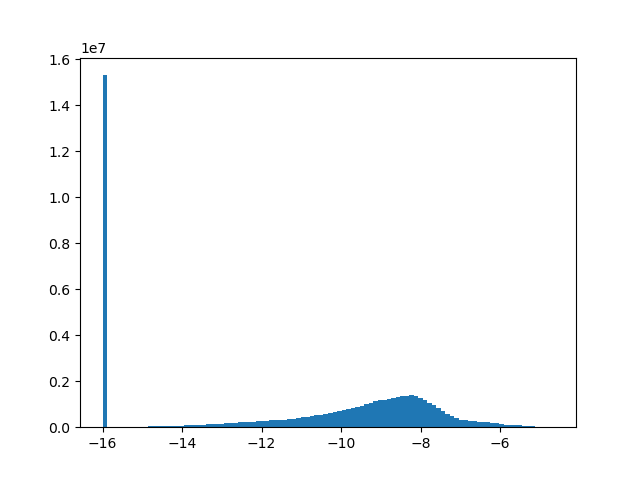

In [202]:
plt.hist(np.log10(final_weights.clip(1e-16)),bins=100) ;

In [ ]:
# How many of the largest concentrations must be retained in order
# for the final answer to be within 1% of exact?

In [204]:
order=np.argsort(-unweighted)
weighted=unweighted*final_weights

running_total=np.cumsum(weighted[order])

total=running_total[-1]

In [207]:
idx99=np.searchsorted(running_total,0.99*total)
print("Summing %d of %d largest concentrations gives 99%% of total concentration"%(idx99,len(final_weights)))
# 16M out of 55M

Summing 16574676 of 55860683 largest concentrations gives 99% of total concentration


In [211]:
# Replicate the opencl test computation
N=50*1024_000
A=np.arange(N)
B=N-A
C=np.zeros_like(A)

# 52ms
%timeit np.add(A,B,out=C)

52.1 ms ± 504 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
